<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>

# Preprocesamiento de Datos para un Modelo de Clasificación

Nuestro equipo de riesgo ha identificado la necesidad de construir un modelo de clasificación para detectar transacciones potencialmente fraudulentas o anómalas. El éxito de este modelo permitirá identificar patrones en los datos y reducir pérdidas económicas para nuestros clientes y la empresa. Tu trabajo para hoy será preparar los datos proporcionados para desarrollar un modelo de clasificación que prediga la probabilidad de que una transacción sea “Normal” o “Anómala”, basándose en las características de las transacciones. Dentro de las tareas que tienes que realizar hoy deben estar incluidas las siguientes: 


1. **Análisis exploratorio de datos (EDA):**

   - Visualizar la distribución de las principales variables.

   - Explorar relaciones entre las características y la variable objetivo (`TransactionStatus`).


2. **Limpieza de datos:**

   - Identificar y tratar valores nulos.

   - Eliminar duplicados si existen.

   - Asegurar que las variables tienen el tipo de dato correcto.

   - etc. 

3. **Transformación de variables:**

   - Normalizar o escalar variables numéricas según sea necesario.

   - Codificar variables categóricas con técnicas como One-Hot Encoding, Target Encoding u Ordinal Encoding, según corresponda.

   - Crear variables derivadas útiles, como:

     - Frecuencia de transacciones de cada cliente.

     - Diferencia de tiempo entre transacciones consecutivas.

     - Ratio entre el saldo posterior y el monto de la transacción.

## Datos Proporcionados

El archivo de datos que analizarán contiene transacciones reales registradas por una compañia. A continuación, se describen las principales columnas que deberán preprocesar:

| Columna               | Descripción                                                                                     |
|-----------------------|-------------------------------------------------------------------------------------------------|
| `transaction_id`      | Identificador único de la transacción.                                                         |
| `customer_id`         | Identificador único del cliente que realizó la transacción.                                    |
| `merchant_id`         | Identificador único del comercio donde se realizó la transacción.                              |
| `amount`              | Monto de la transacción (en la moneda correspondiente).                                        |
| `transaction_time`    | Fecha y hora exacta en la que ocurrió la transacción.                                          |
| `is_fraudulent`       | Indicador de si la transacción fue fraudulenta (1: Sí, 0: No).                                 |
| `card_type`           | Tipo de tarjeta utilizada para la transacción (Visa, MasterCard, American Express, Discover).  |
| `location`            | Ubicación (ciudad o región) donde se realizó la transacción.                                   |
| `purchase_category`   | Categoría de la compra (por ejemplo, Gas Station, Online Shopping, Retail, etc.).              |
| `customer_age`        | Edad del cliente en el momento de la transacción.                                              |
| `transaction_description` | Descripción breve de la transacción, usualmente incluye el comercio asociado.              |


In [1]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Otros objetivos
# -----------------------------------------------------------------------
import math
import numpy as np

# Gráficos
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt


# Para tratar el problema de desbalance
# -----------------------------------------------------------------------
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek


#Librerías de soporte
#------------------------------------------------------------------------
import sys
sys.path.append("../")
from src import soporte
from src import soporte_encoding as s_e


from itertools import product, combinations
from scipy.stats import chi2_contingency


In [2]:
df = pd.read_csv("datos_labs/financial_data.csv")
df.columns

Index(['transaction_id', 'customer_id', 'merchant_id', 'amount',
       'transaction_time', 'is_fraudulent', 'card_type', 'location',
       'purchase_category', 'customer_age', 'transaction_description'],
      dtype='object')

# EDA

No hay nulos en el dataset. Tampoco hay duplicados.

In [3]:
soporte.exploracion_dataframe(df,"is_fraudulent")

El número de datos es 10000 y el de columnas es 11

 ..................... 

Los duplicados que tenemos en el conjunto de datos son: 0

 ..................... 

Los nulos que tenemos en el conjunto de datos son:


,%_nulos



 ..................... 

Los tipos de las columnas son:


,tipo_dato
transaction_id,int64
customer_id,int64
merchant_id,int64
amount,float64
transaction_time,object
is_fraudulent,int64
card_type,object
location,object
purchase_category,object
customer_age,int64



 ..................... 

Los valores que tenemos para las columnas categóricas son: 
La columna TRANSACTION_TIME tiene las siguientes valore únicos:


,count
transaction_time,
2023-01-01 00:00:00,1
2023-01-01 01:51:10,1
2023-01-01 01:51:03,1
2023-01-01 01:51:04,1
2023-01-01 01:51:05,1


La columna CARD_TYPE tiene las siguientes valore únicos:


,count
card_type,
Discover,2633
American Express,2494
Visa,2490
MasterCard,2383


La columna LOCATION tiene las siguientes valore únicos:


,count
location,
City-7,223
City-40,221
City-41,218
City-14,218
City-32,218


La columna PURCHASE_CATEGORY tiene las siguientes valore únicos:


,count
purchase_category,
Travel,1694
Groceries,1692
Gas Station,1666
Retail,1661
Online Shopping,1651


La columna TRANSACTION_DESCRIPTION tiene las siguientes valore únicos:


,count
transaction_description,
Purchase at Merchant-2016,120
Purchase at Merchant-2078,120
Purchase at Merchant-2055,118
Purchase at Merchant-2013,117
Purchase at Merchant-2057,117



 ..................... 

Los principales estadísticos de las columnas numéricas para 0 son: 


,count,mean,std,min,25%,50%,75%,max
transaction_id,4932.0,4994.672547,2899.873398,1.00,2483.25,4970.50,7480.2500,9998.00
customer_id,4932.0,1051.447283,28.744785,1001.00,1026.00,1052.00,1076.0000,1100.00
merchant_id,4932.0,2050.010138,28.894789,2001.00,2025.00,2050.00,2075.0000,2100.00
amount,4932.0,4943.229469,2885.005398,11.33,2450.11,4958.17,7455.6375,9998.21
is_fraudulent,4932.0,0.000000,0.000000,0.00,0.00,0.00,0.0000,0.00
customer_age,4932.0,44.131184,15.270322,18.00,31.00,44.00,57.0000,70.00



 ..................... 

Los principales estadísticos de las columnas numéricas para 1 son: 


,count,mean,std,min,25%,50%,75%,max
transaction_id,5068.0,5006.171073,2874.484800,2.00,2529.0000,5029.50,7521.25,10000.00
customer_id,5068.0,1051.102013,28.981488,1001.00,1026.0000,1051.00,1077.00,1100.00
merchant_id,5068.0,2050.950276,28.856557,2001.00,2026.0000,2051.00,2076.00,2100.00
amount,5068.0,4973.127157,2914.137479,10.61,2421.8225,4922.06,7532.90,9999.75
is_fraudulent,5068.0,1.000000,0.000000,1.00,1.0000,1.00,1.00,1.00
customer_age,5068.0,43.966062,15.372618,18.00,30.0000,44.00,57.00,70.00


## Echamos un ojo a las distribuciones tanto visual como con estadísticamente

Vemos que los ids son prácticamente distribuciones uniformes . Is fraudulent es una variable binaria que usaremos para hacer AB testing

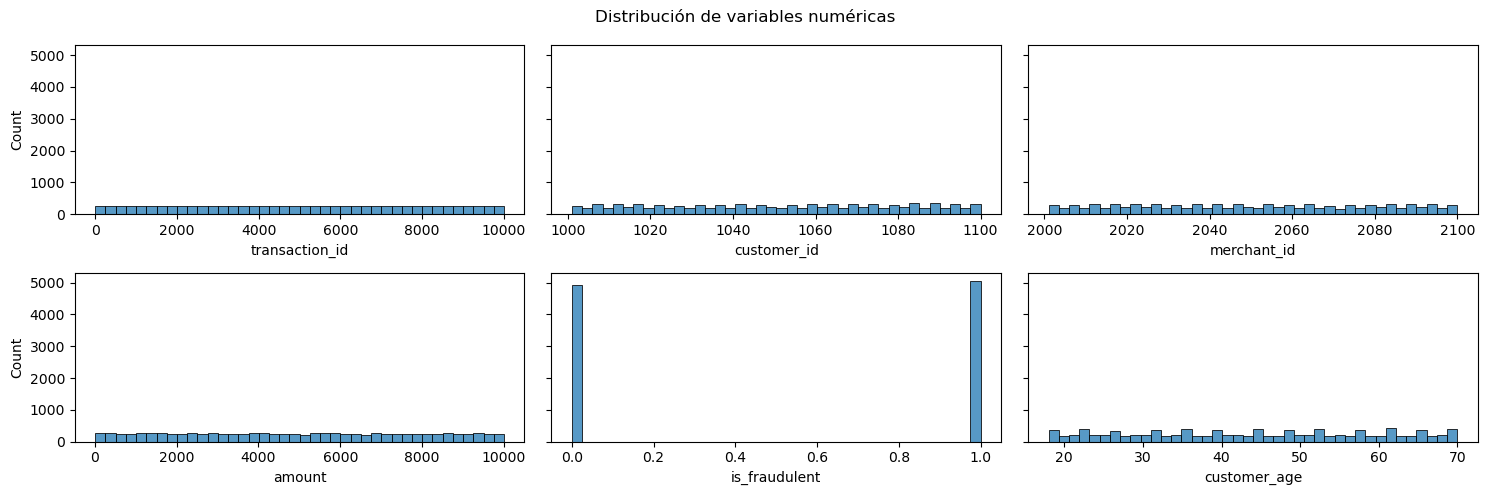

In [4]:
visual = soporte.Visualizador(df)
visual.plot_numericas(palette= "Set1")

Por lo que hemos visto de los datos, pasamos transaction time a datetime y transaction_description lo eliminamos, pues es igual a "merchant_id"


In [5]:
df.dtypes

transaction_id               int64
customer_id                  int64
merchant_id                  int64
amount                     float64
transaction_time            object
is_fraudulent                int64
card_type                   object
location                    object
purchase_category           object
customer_age                 int64
transaction_description     object
dtype: object

In [6]:
df["transaction_time"] = pd.to_datetime(df["transaction_time"])

all(df["transaction_description"].str.replace("Purchase at Merchant-", "").astype(int) == df["merchant_id"])
df.drop(columns = ["transaction_description"],inplace=True)

Observamos la distribución de los datos categóricos. Nada extraño

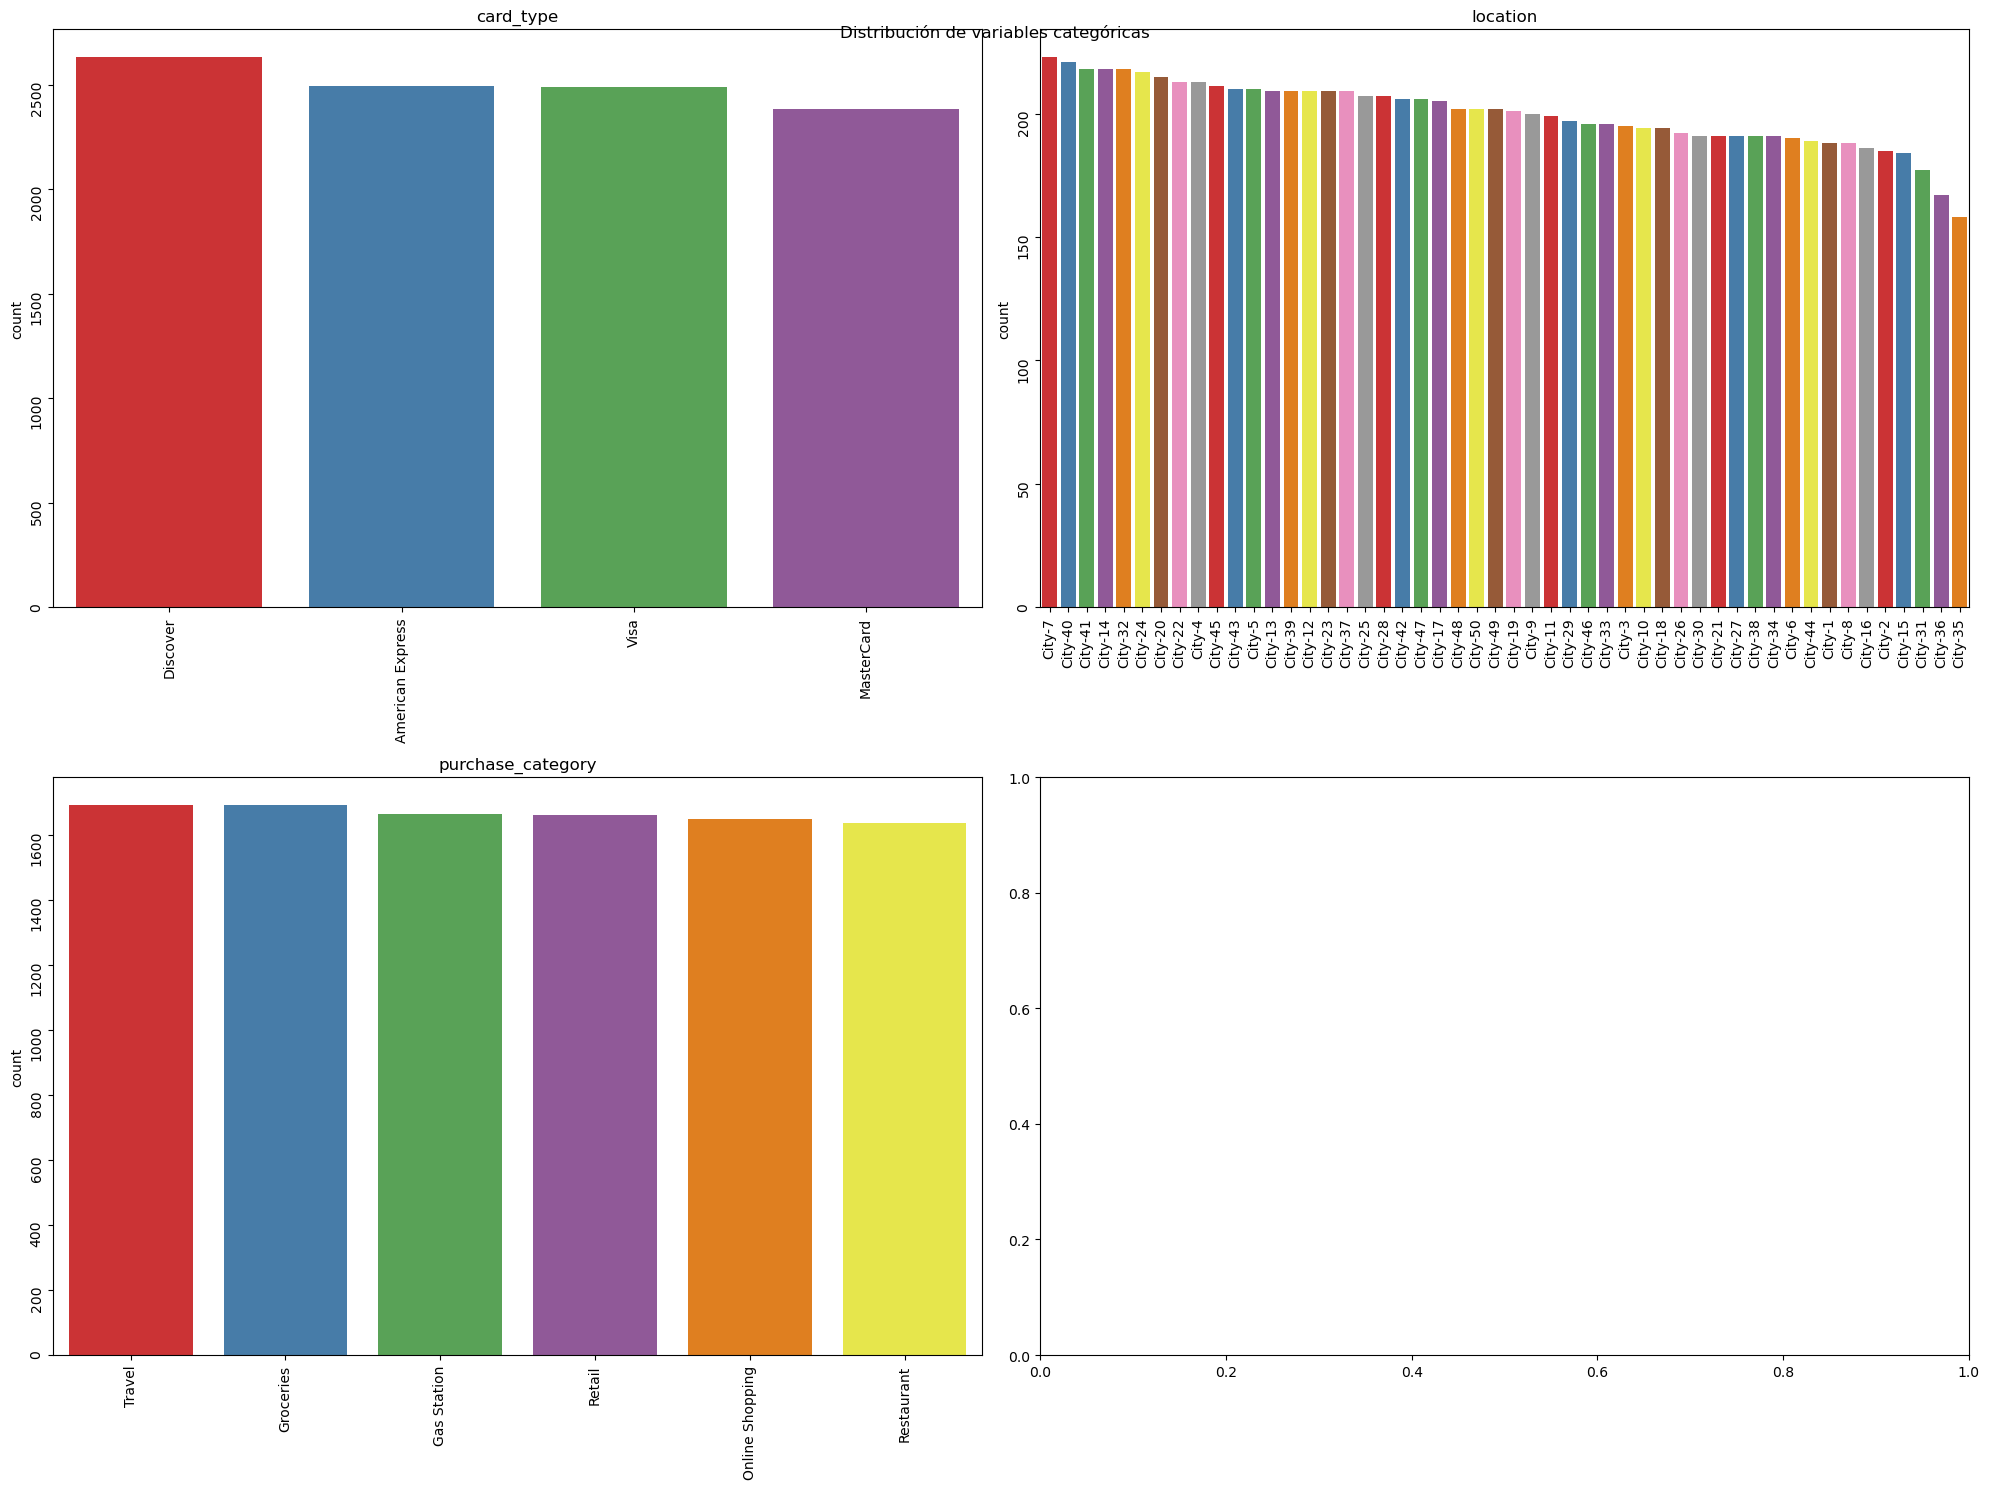

In [7]:
df_num,df_cat = visual.separar_dataframes()
visual.plot_categoricas(tamano_grafica= (20,15))

# Outliers

En un análisis visual de los outliers de cada grupo, vemos que no hay ningún valor atípico a primera vista. Los subgrupos de "location" son binarios mientras que los demás son uniformes

In [ ]:
outliers_uni = soporte.GestionOutliersUnivariados(df)
outliers_uni.visualizar_outliers_univariados()
df_num.columns

In [ ]:
df_cat.columns
df_num.columns

Index(['transaction_id', 'customer_id', 'merchant_id', 'amount',
       'is_fraudulent', 'customer_age'],
      dtype='object')

Index(['transaction_id', 'customer_id', 'merchant_id', 'amount',
       'is_fraudulent', 'customer_age'],
      dtype='object')

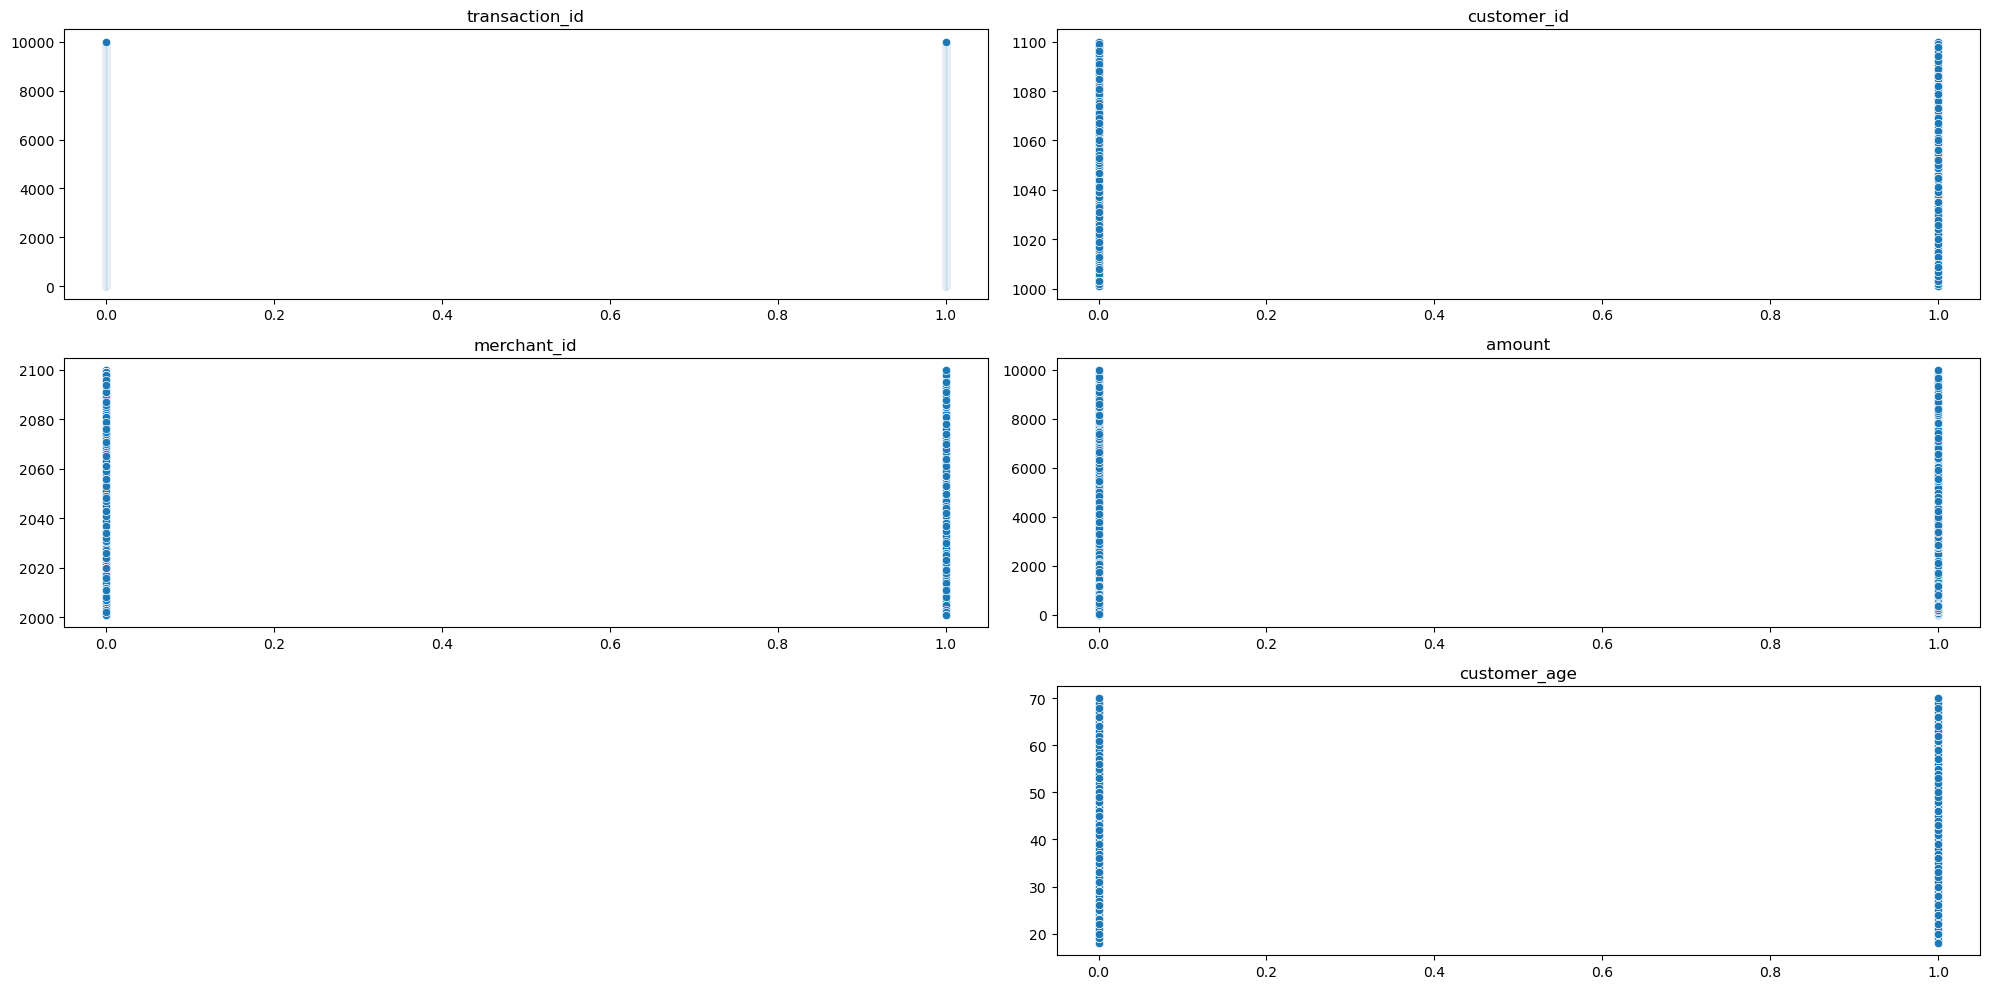

In [ ]:
gestion_multivariados = soporte.GestionOutliersMultivariados(df_num)
gestion_multivariados.visualizar_outliers_bivariados("is_fraudulent",tamano_grafica=(20,10))
df_num.columns

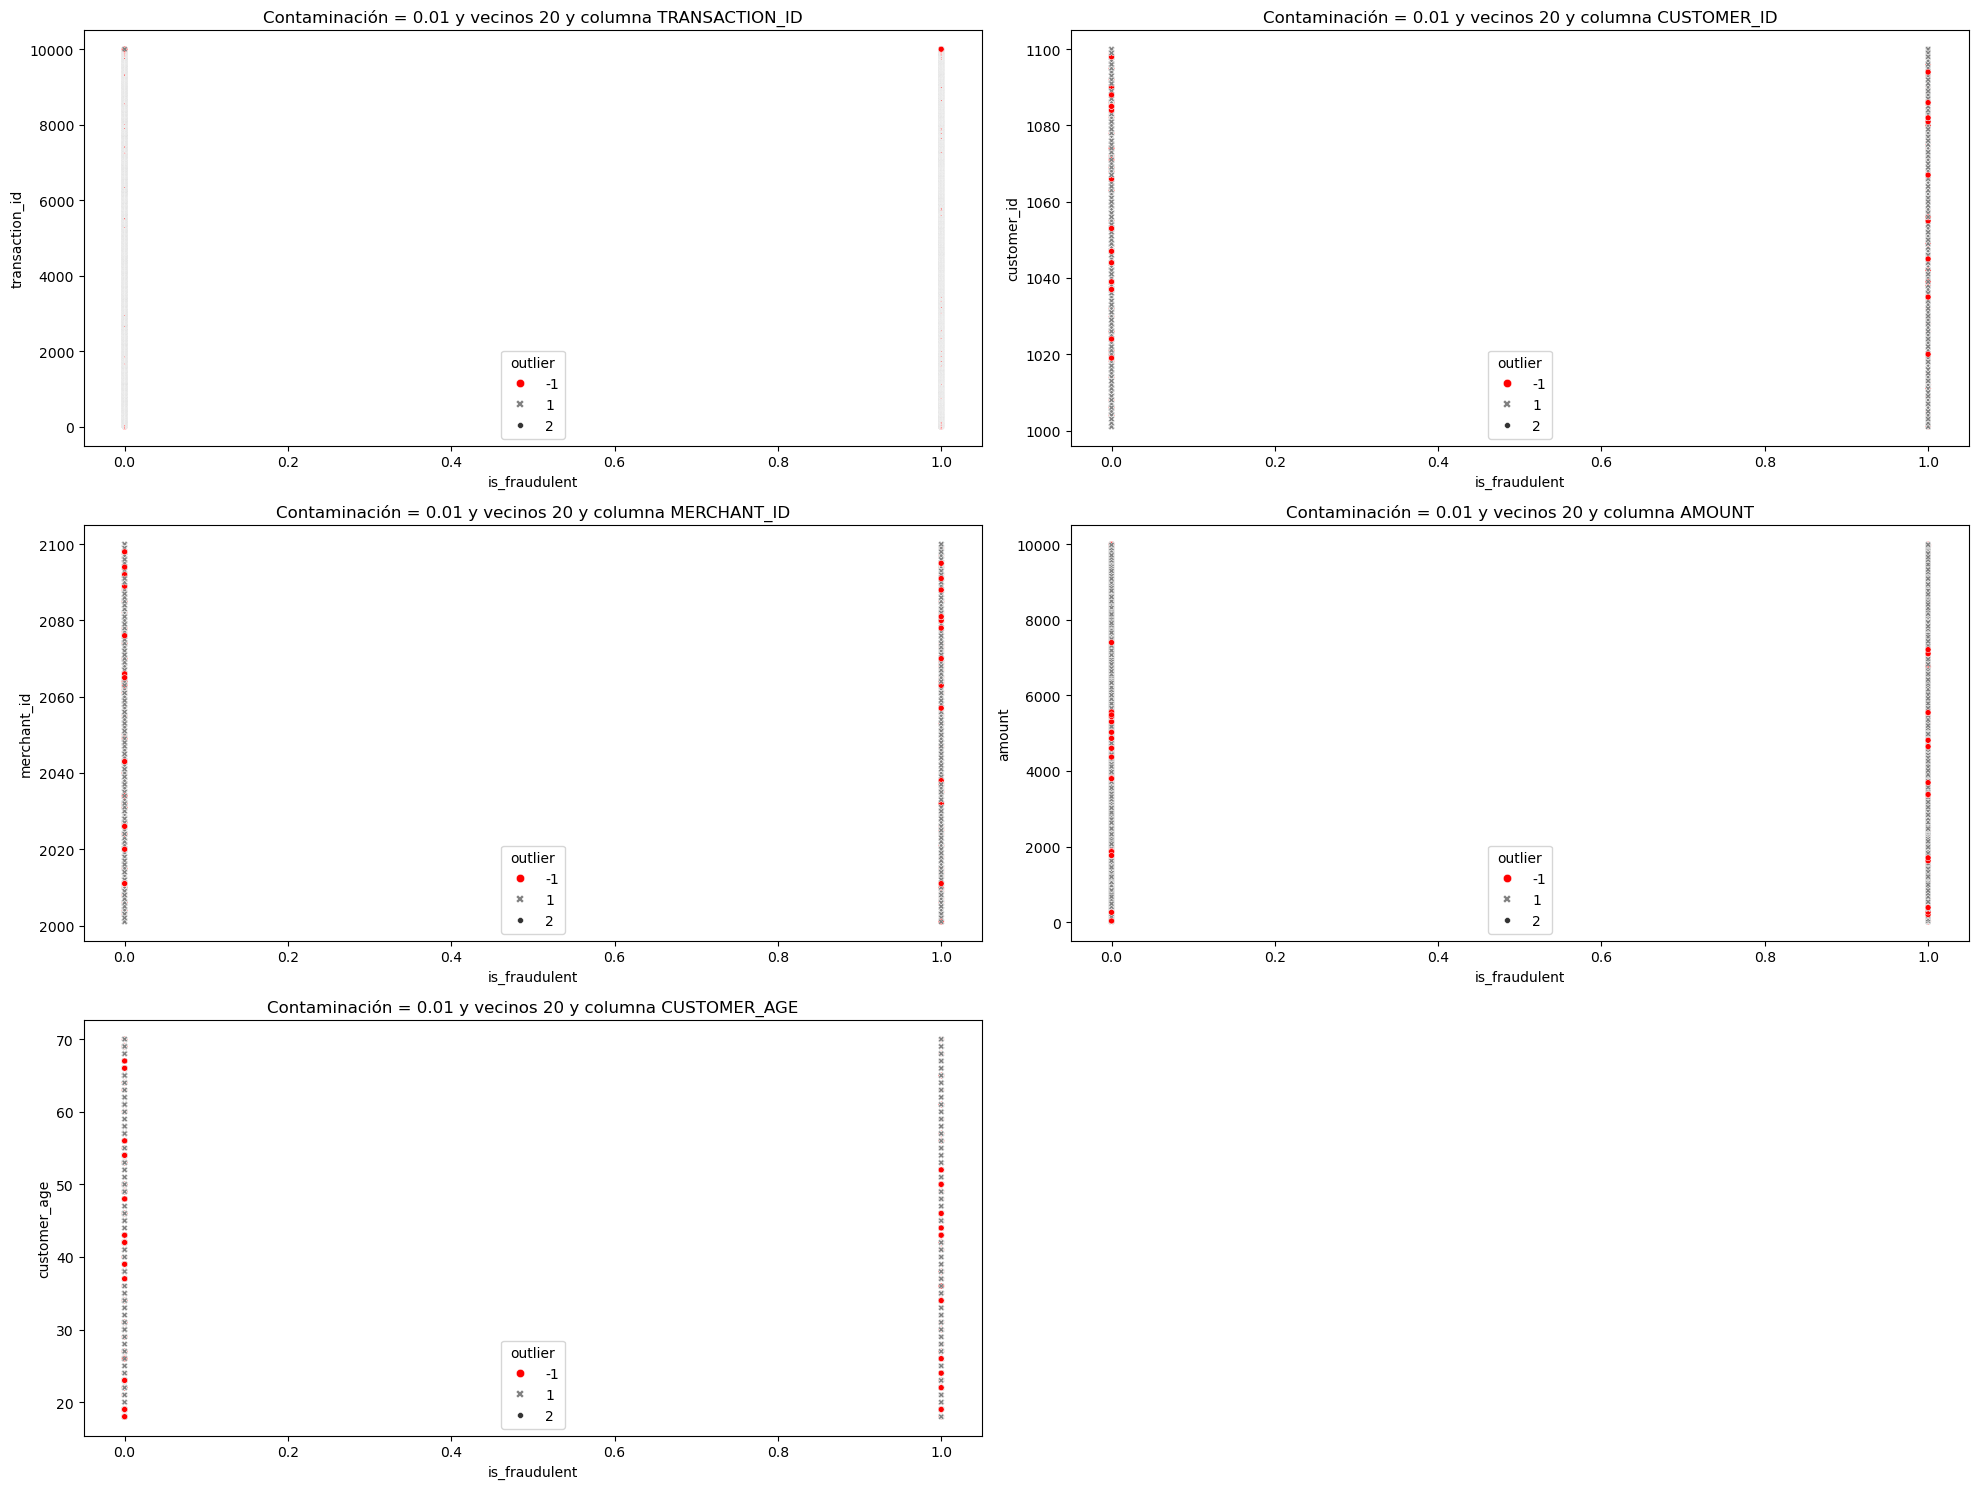

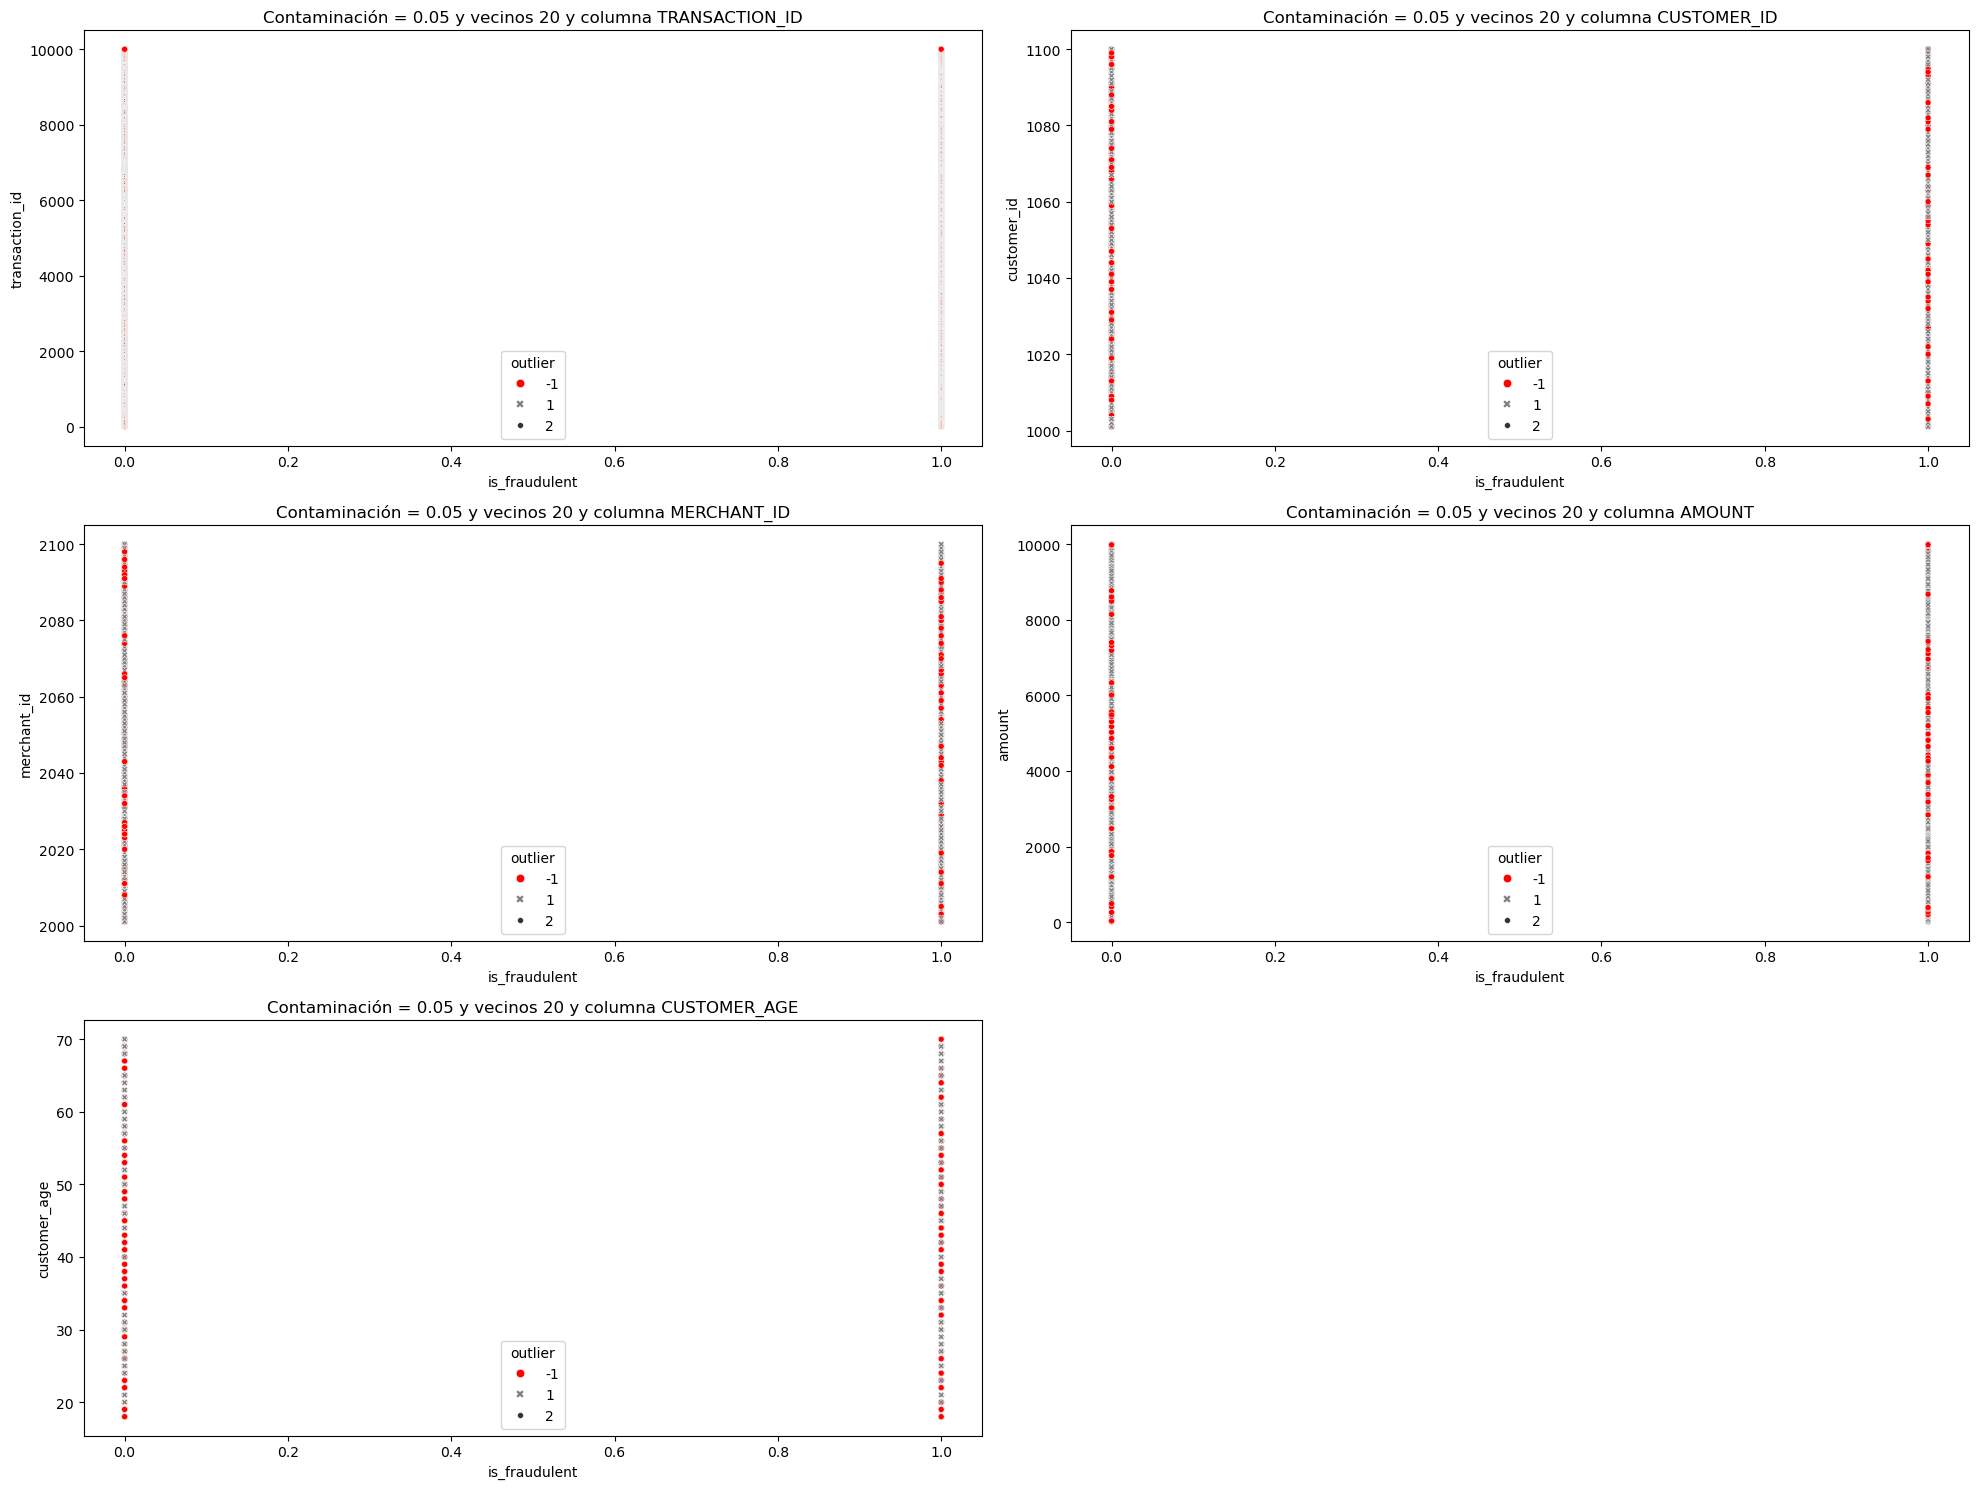

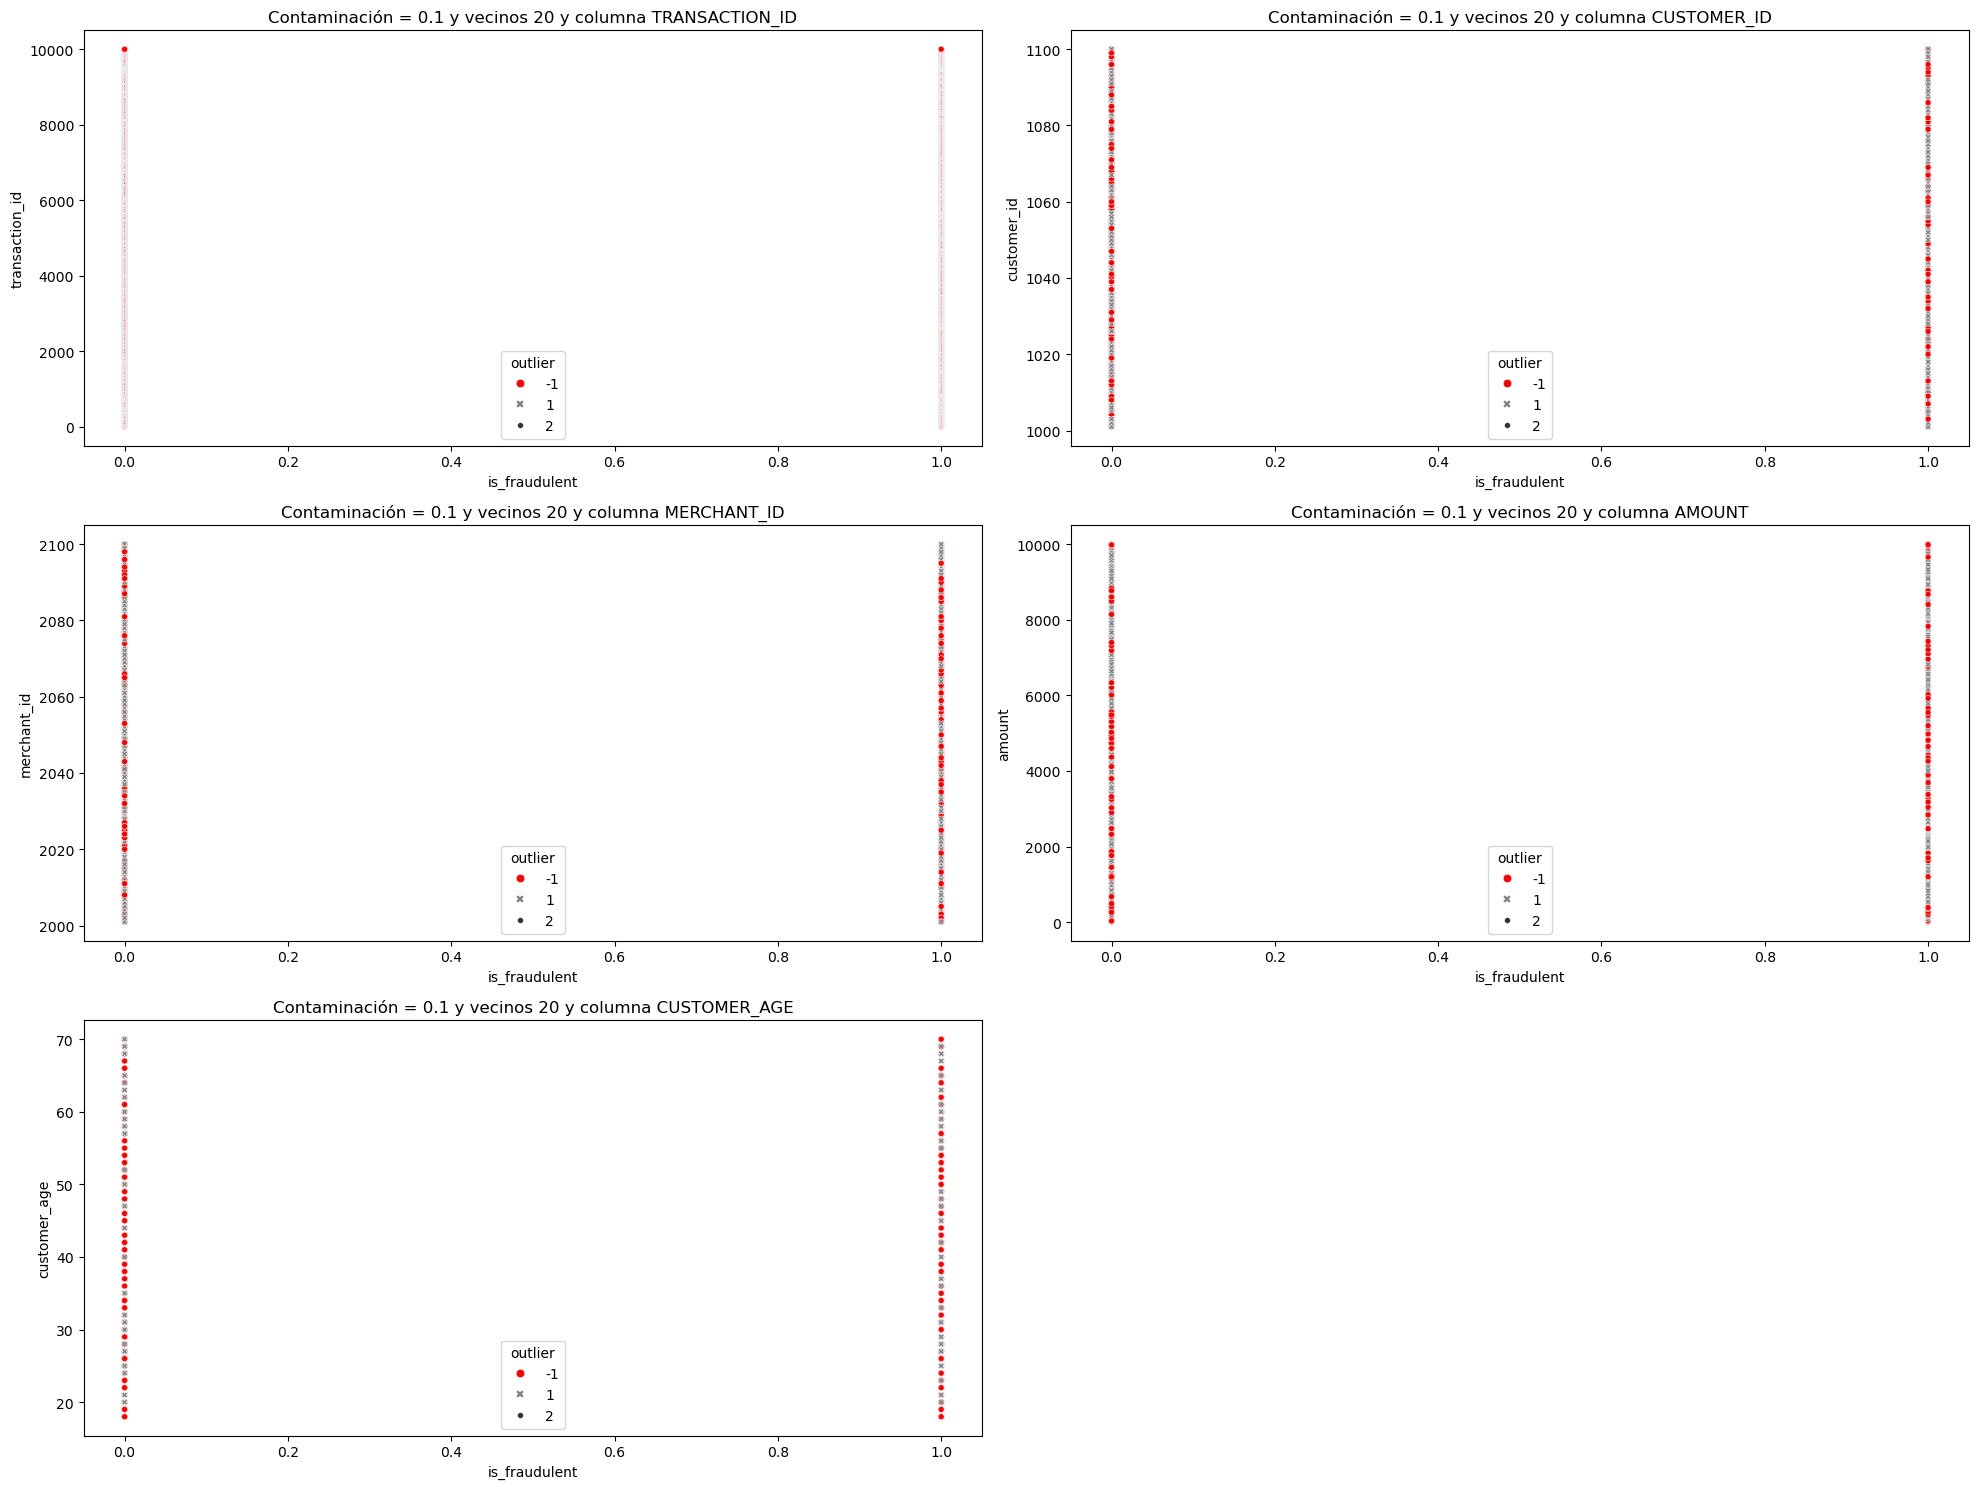

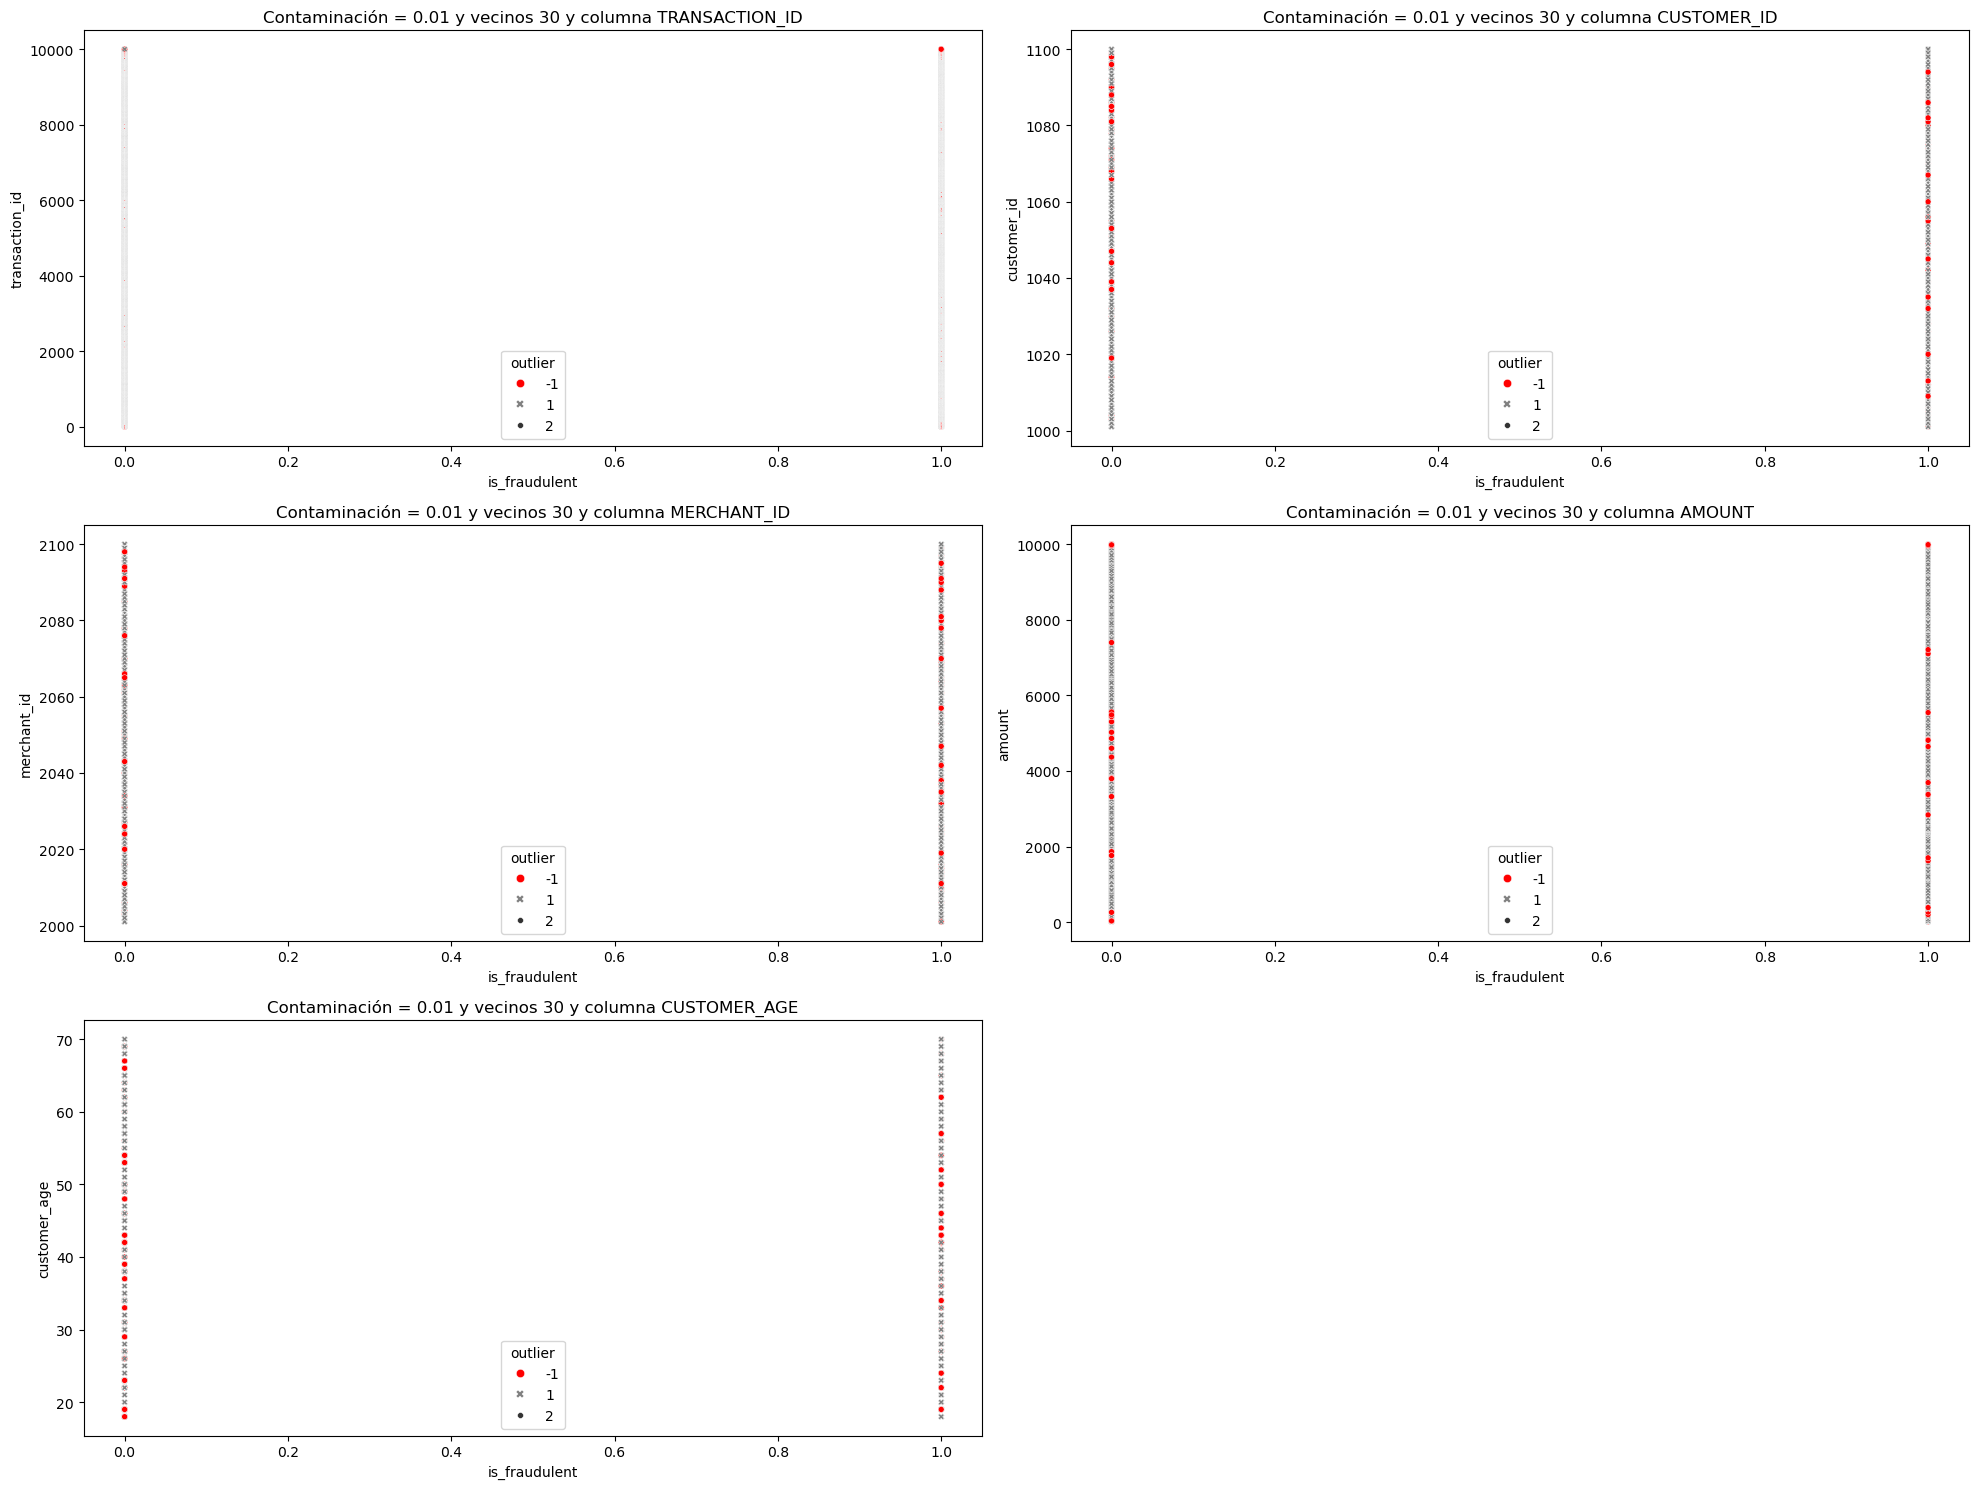

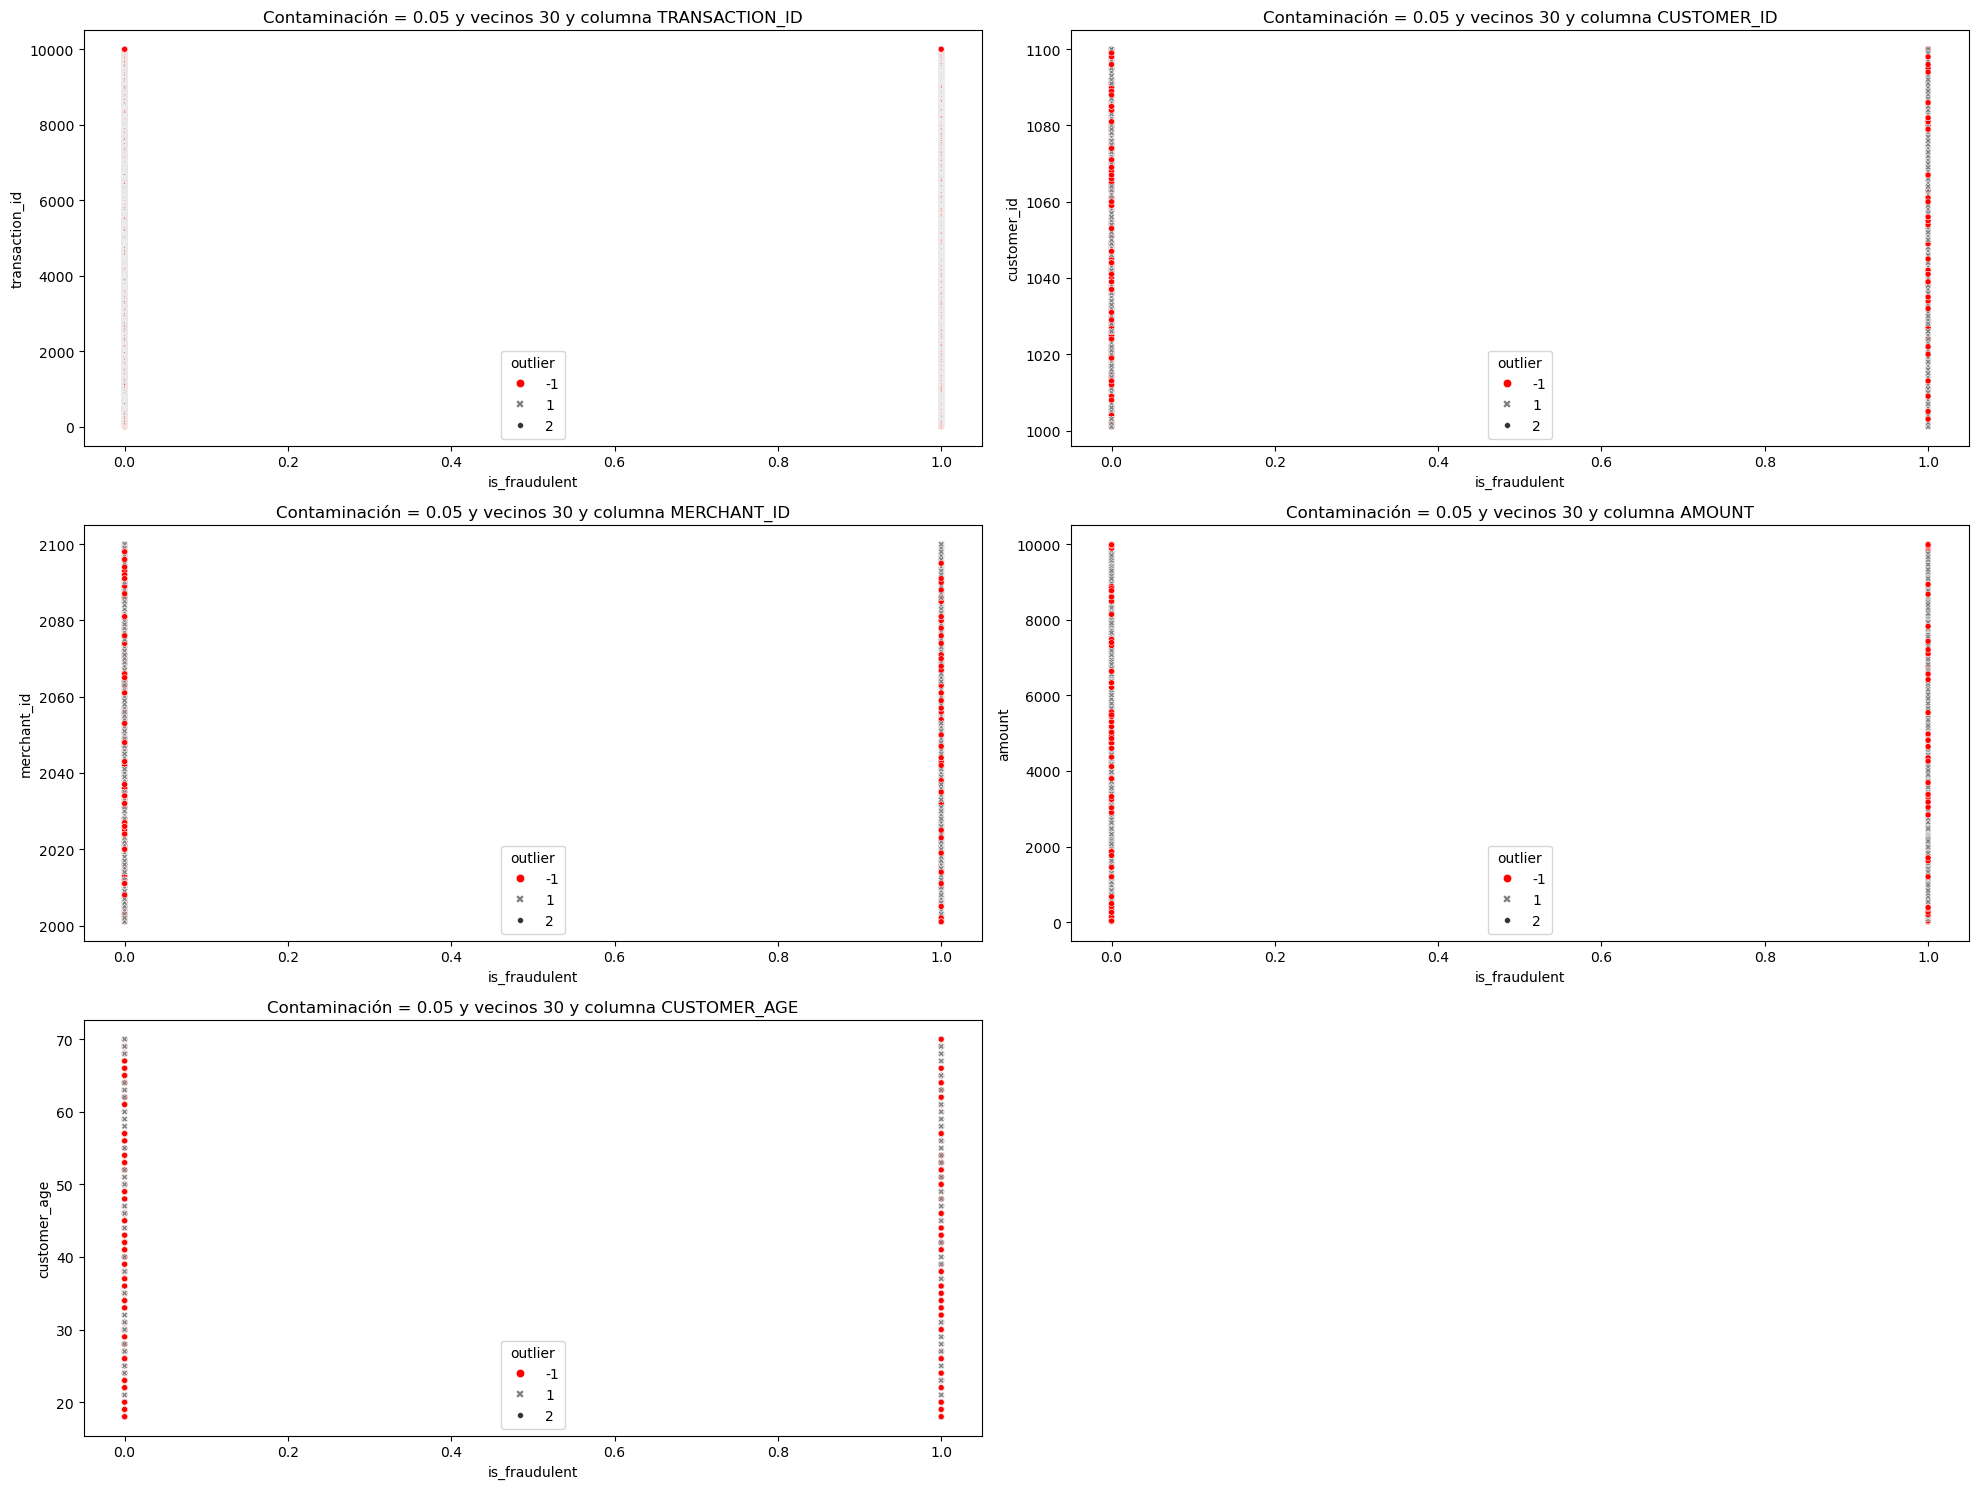

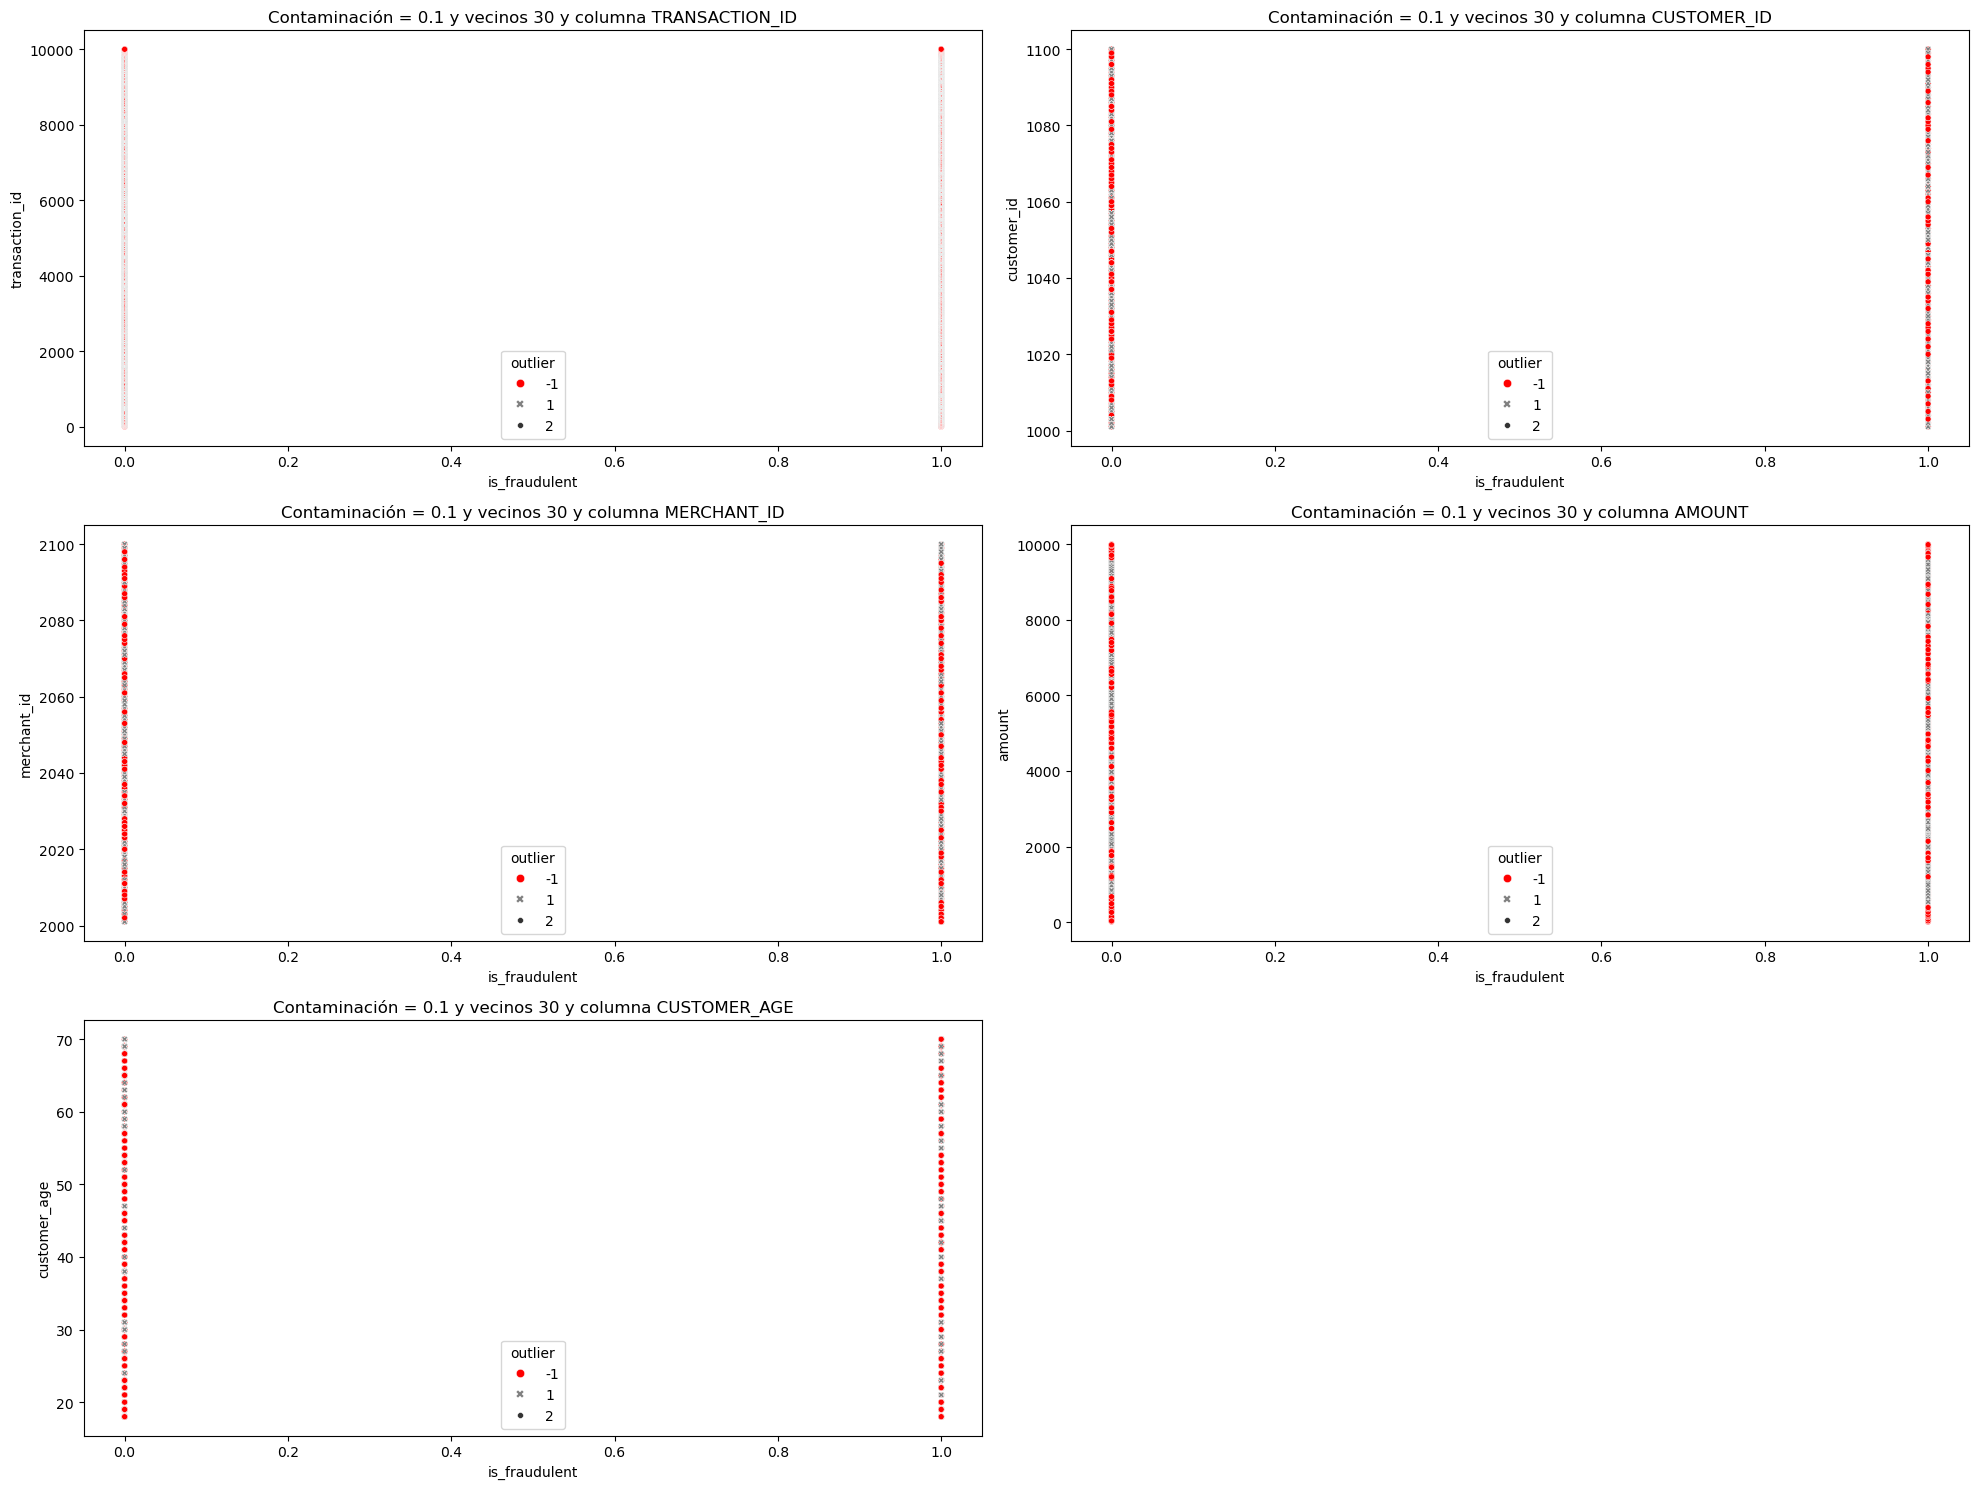

In [ ]:
lista_cols = df_num.columns

gestion_multivariados.explorar_outliers_lof("is_fraudulent")

df_lof = gestion_multivariados.detectar_outliers_lof(list_neighbors=[5,10,20],col_numericas=lista_cols)


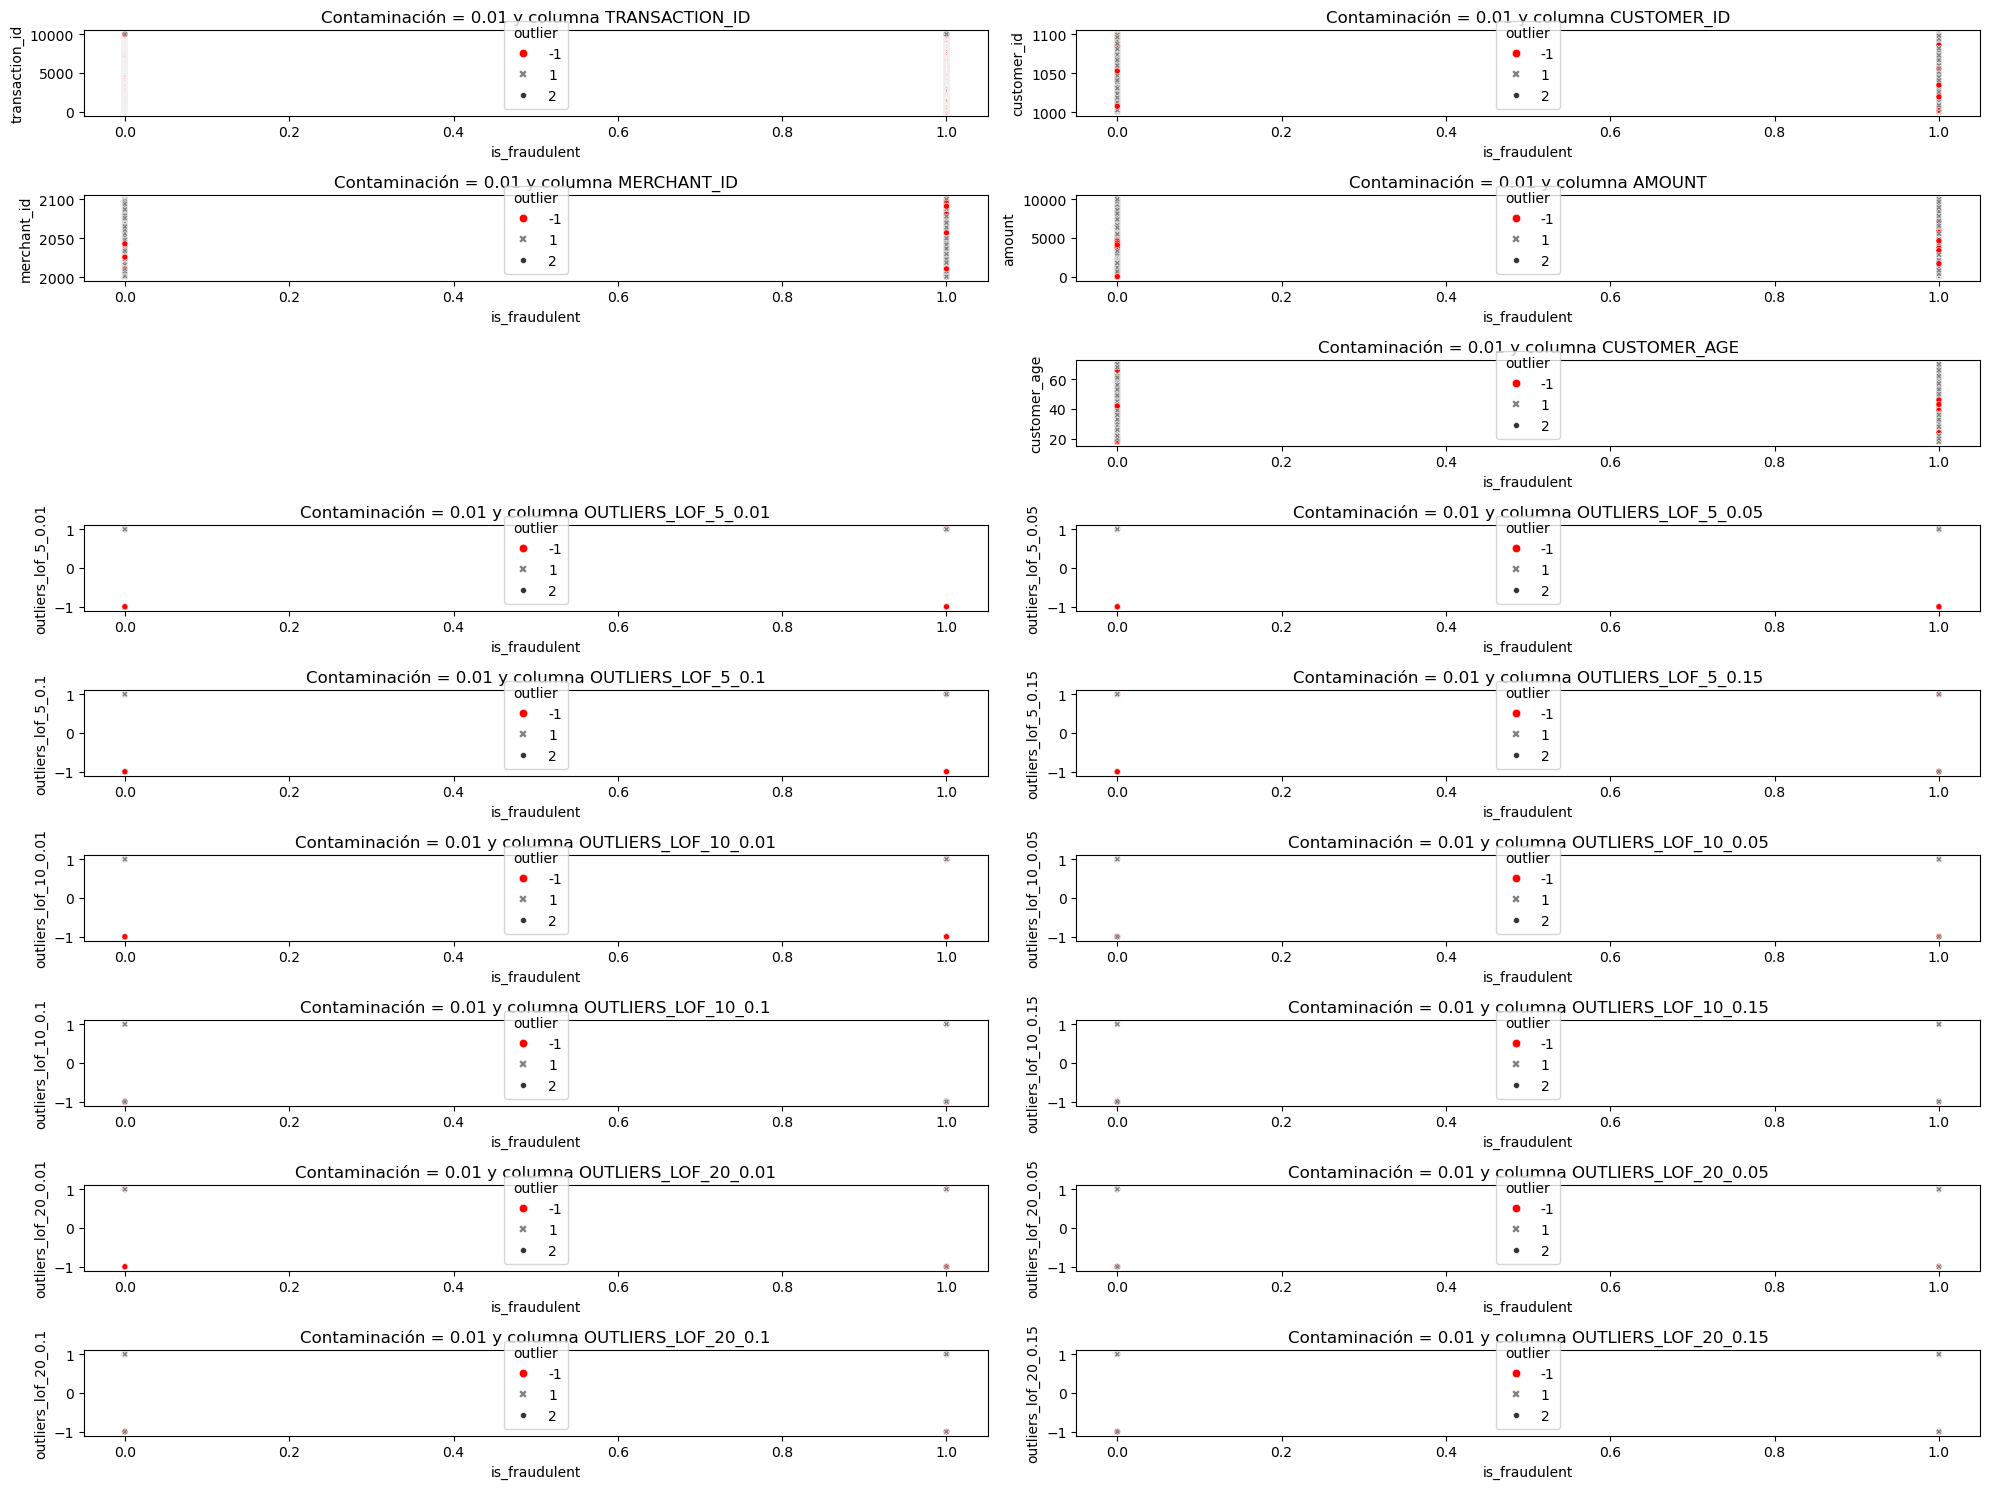

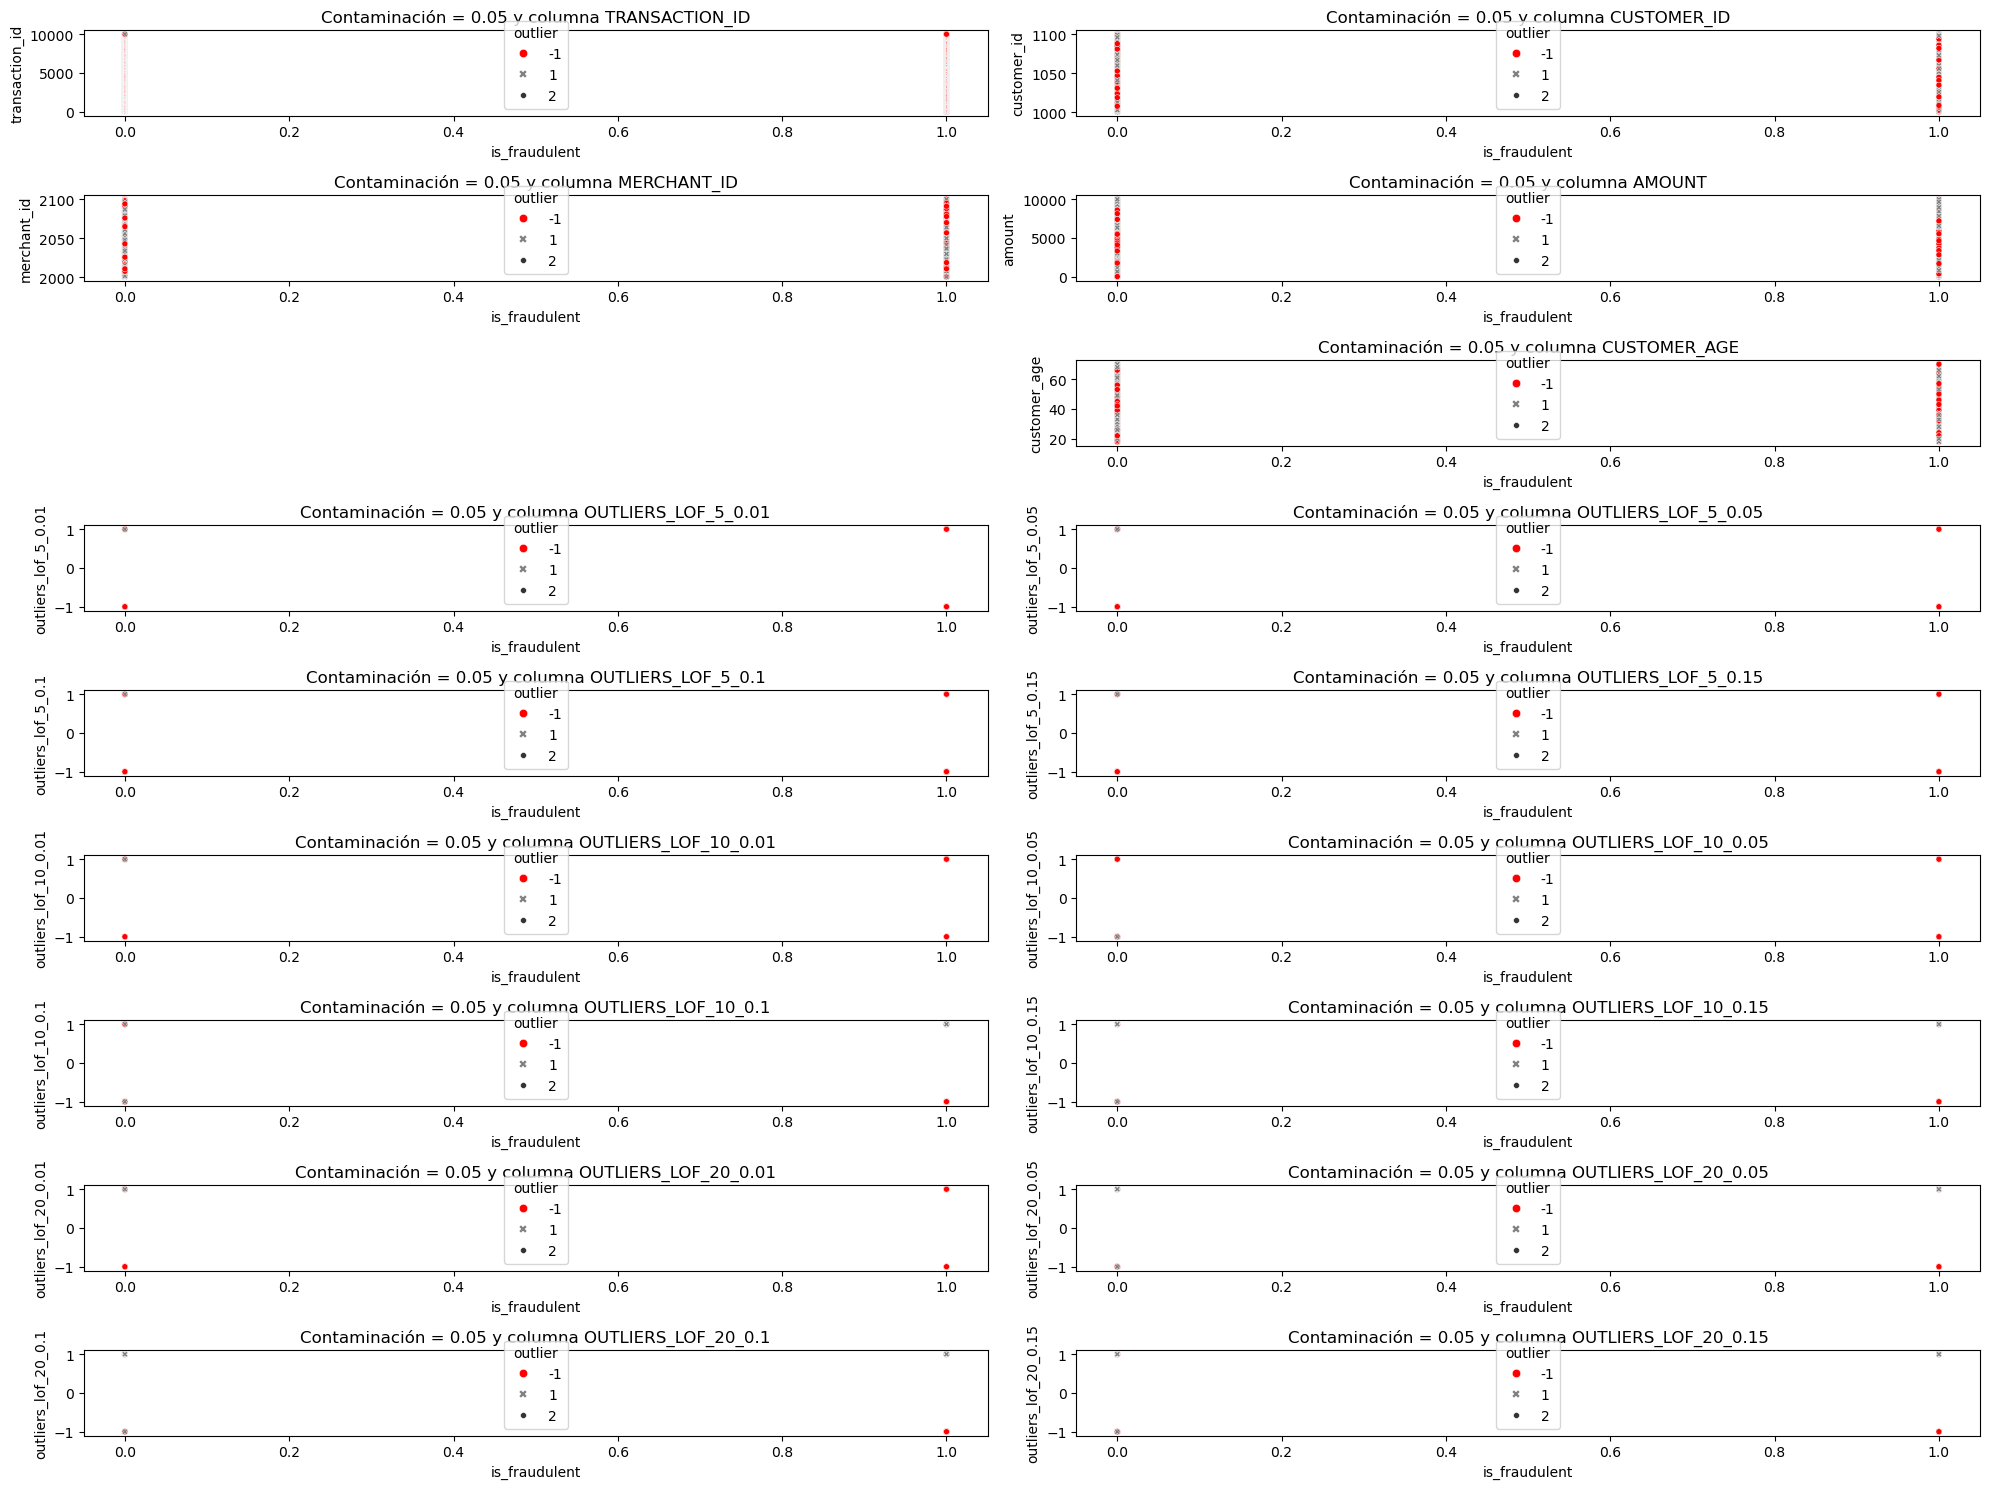

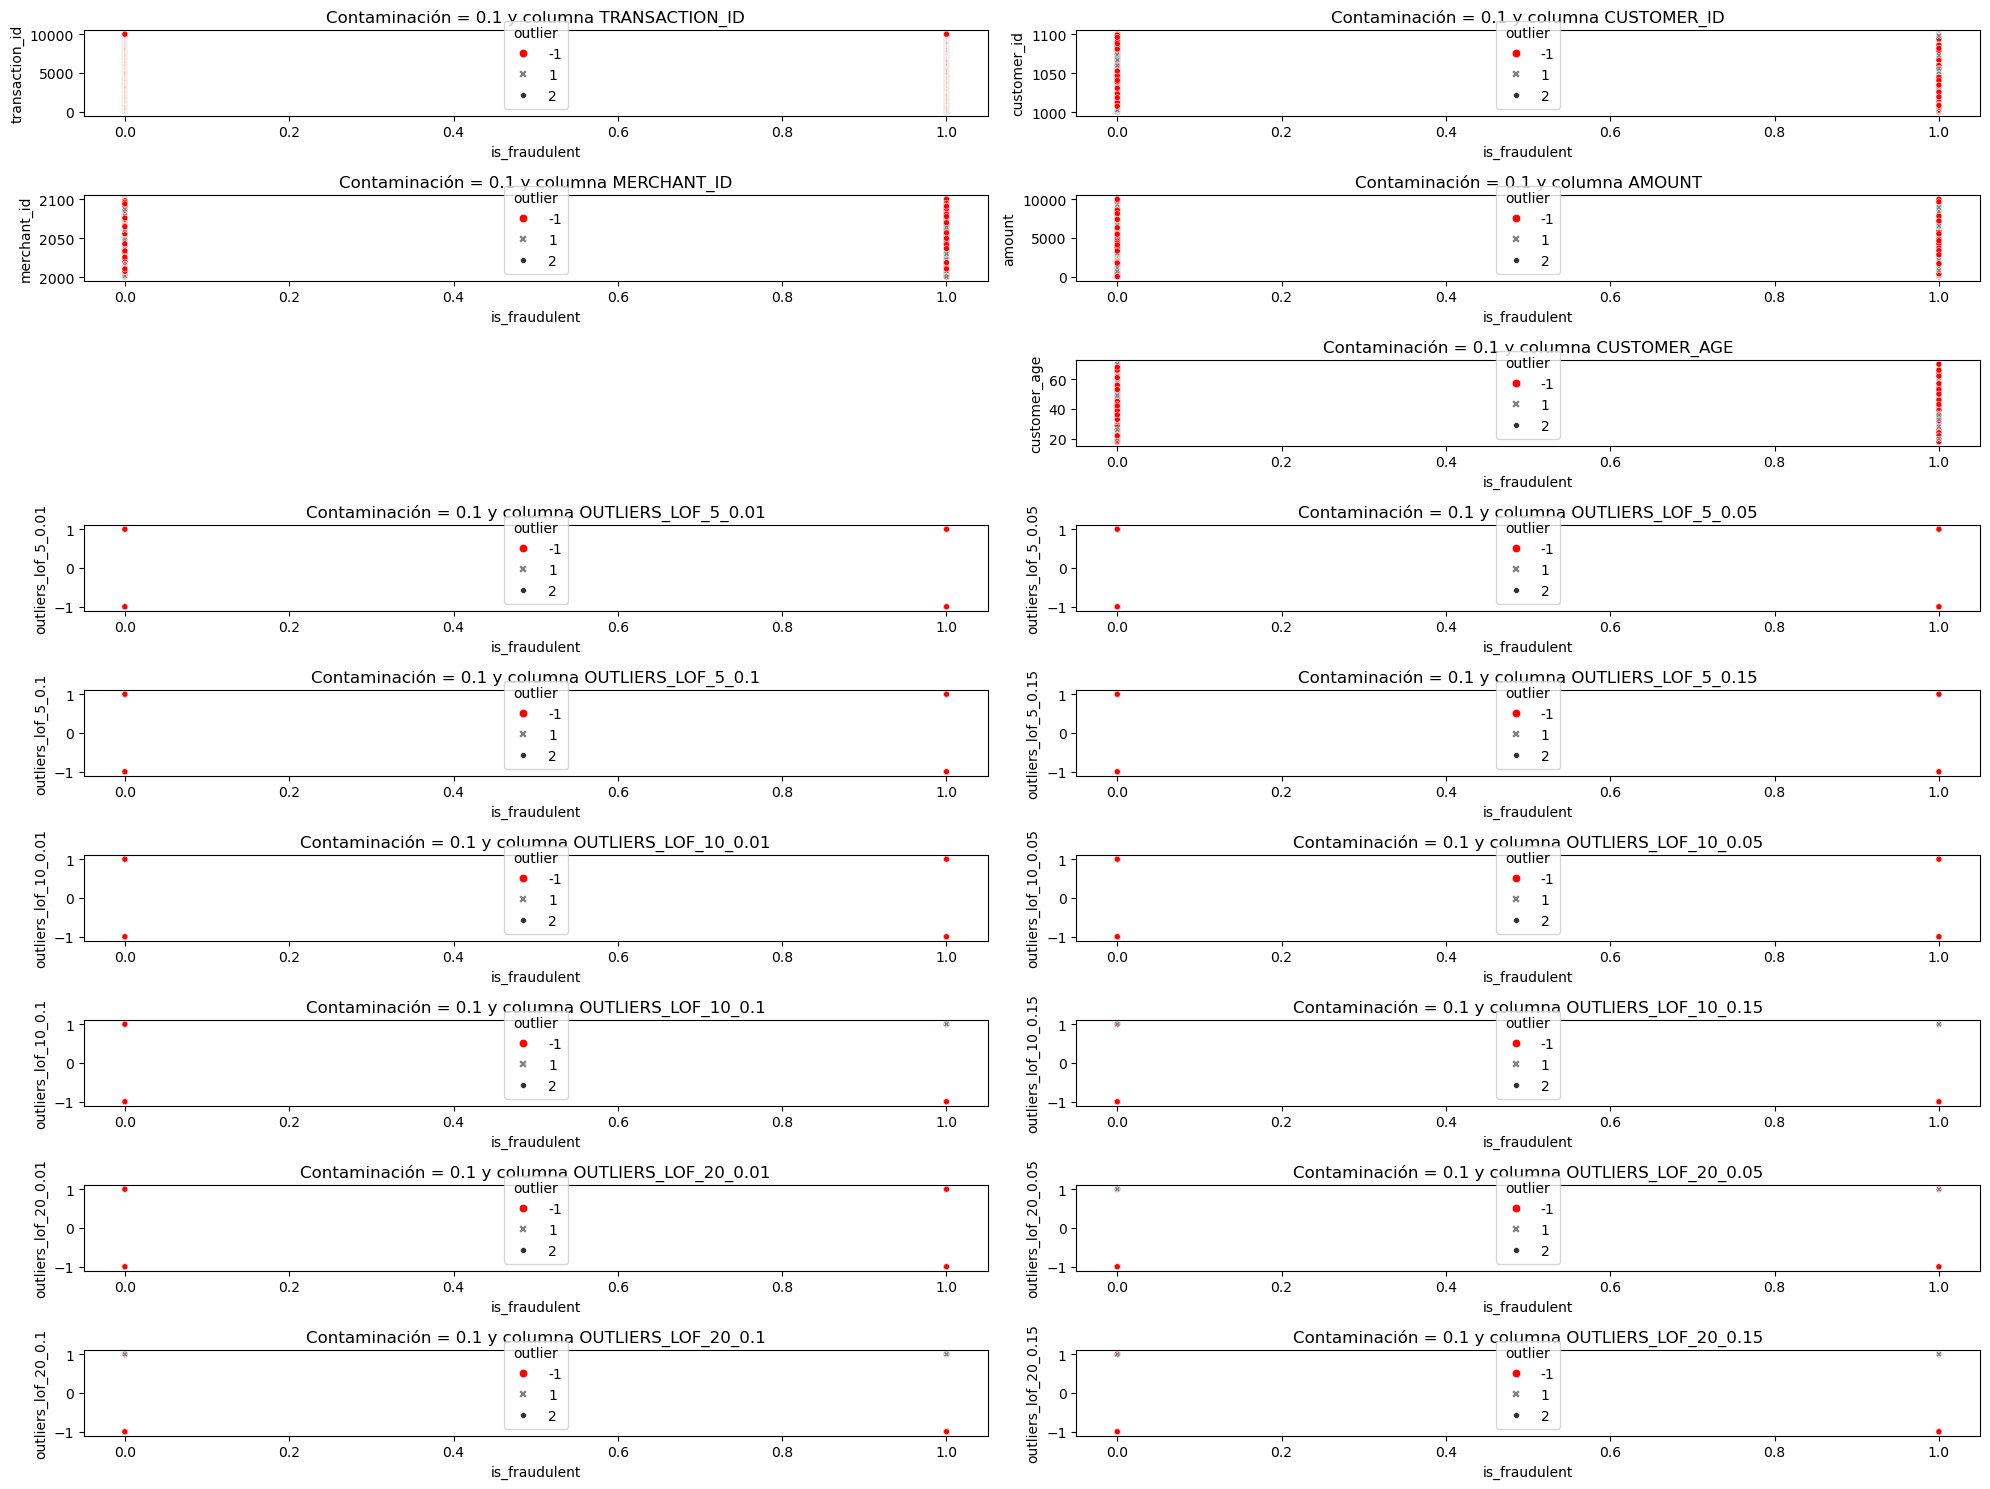

In [ ]:
gestion_multivariados.explorar_outliers_if("is_fraudulent")
df_ifo = gestion_multivariados.detectar_outliers_if

Index(['transaction_id', 'customer_id', 'merchant_id', 'amount',
       'transaction_time', 'is_fraudulent', 'card_type', 'location',
       'purchase_category', 'customer_age', 'card_type_American Express',
       'card_type_Discover', 'card_type_MasterCard', 'card_type_Visa',
       'location_City-1', 'location_City-10', 'location_City-11',
       'location_City-12', 'location_City-13', 'location_City-14',
       'location_City-15', 'location_City-16', 'location_City-17',
       'location_City-18', 'location_City-19', 'location_City-2',
       'location_City-20', 'location_City-21', 'location_City-22',
       'location_City-23', 'location_City-24', 'location_City-25',
       'location_City-26', 'location_City-27', 'location_City-28',
       'location_City-29', 'location_City-3', 'location_City-30',
       'location_City-31', 'location_City-32', 'location_City-33',
       'location_City-34', 'location_City-35', 'location_City-36',
       'location_City-37', 'location_City-38', 'locati

# Encoding

Vemos las diferencias para las columnas categóricas

In [ ]:
lista_cats = df_cat.columns
tests = s_e.TestEstadisticos(df,"is_fraudulent",lista_cats)
dic = tests.detectar_orden_binaria()

Esta es la tabla de contingencia para card_type, con la variable respuesta is_fraudulent
is_fraudulent        0     1
card_type                   
American Express  1262  1232
Discover          1304  1329
MasterCard        1140  1243
Visa              1226  1264
La variable categórica NO TIENE ORDEN
-----
Esta es la tabla de contingencia para location, con la variable respuesta is_fraudulent
is_fraudulent    0    1
location               
City-1          80  108
City-10        100   94
City-11         92  107
City-12        102  107
City-13         99  110
City-14        106  112
City-15         96   88
City-16         92   94
City-17        109   96
City-18         89  105
City-19        103   98
City-2          97   88
City-20        102  113
City-21         92   99
City-22        119   94
City-23         95  114
City-24        114  103
City-25        104  103
City-26         83  109
City-27         95   96
City-28         95  112
City-29         94  103
City-3          99   96
City-

Printeamos el diccionario para las diferencias y lo aplicamos al encoding:


In [ ]:
dic

{'card_type': 0, 'location': 0, 'purchase_category': 1}

In [ ]:
columnas_sin_orden = [col for col, orden in dic.items() if orden == 0]
columnas_con_orden = [col for col, orden in dic.items() if orden == 1]
dic_encoding = {"onehot":columnas_sin_orden,
              "target":columnas_con_orden}

In [ ]:
dic_encoding

{'onehot': ['card_type', 'location'], 'target': ['purchase_category']}

In [ ]:
encoding = s_e.Encoding(df,dic_encoding,"is_fraudulent")
df = encoding.target_encoding()
df = encoding.one_hot_encoding()
df

,transaction_id,customer_id,merchant_id,amount,transaction_time,is_fraudulent,card_type,location,purchase_category,customer_age,...,location_City-46,location_City-47,location_City-48,location_City-49,location_City-5,location_City-50,location_City-6,location_City-7,location_City-8,location_City-9
0,1,1082,2027,5758.59,2023-01-01 00:00:00,0,MasterCard,City-30,0.524610,43,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1015,2053,1901.56,2023-01-01 00:00:01,1,Visa,City-47,0.486978,61,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1004,2035,1248.86,2023-01-01 00:00:02,1,MasterCard,City-6,0.524610,57,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,4,1095,2037,7619.05,2023-01-01 00:00:03,1,Discover,City-6,0.505313,59,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,5,1036,2083,1890.10,2023-01-01 00:00:04,1,MasterCard,City-34,0.513546,36,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,1056,2023,8935.28,2023-01-01 02:46:35,1,MasterCard,City-39,0.479829,36,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,9997,1053,2026,30.15,2023-01-01 02:46:36,0,MasterCard,City-32,0.513546,42,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,9998,1041,2034,6333.64,2023-01-01 02:46:37,0,American Express,City-1,0.486978,36,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,9999,1009,2019,2837.13,2023-01-01 02:46:38,1,Visa,City-11,0.513546,57,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>

# Laboratorio: Construcción Modelo de Clasificación y Evaluación de Métricas

Tras realizar el preprocesamiento de los datos y dejarlos listos para construir modelos, ha llegado el momento de dar el siguiente paso: desarrollar tu **primer modelo de clasificación**.

El objetivo de este laboratorio es implementar un modelo de clasificación inicial utilizando **Regresión Logística (Logistic Regression)**. Este modelo te permitirá obtener las primeras predicciones para identificar transacciones normales y anómalas, así como evaluar su desempeño utilizando métricas estándar.

Además, deberás evaluar si el modelo está en riesgo de **overfitting**, asegurando que nuestras predicciones sean consistentes tanto en los datos de entrenamiento como en los de prueba.


## Objetivo del Laboratorio

1. Entrenar un modelo de **Regresión Logística** para predecir si una transacción es "Normal" o "Anómala".

2. Evaluar el desempeño del modelo utilizando métricas como:

   - Precisión (Accuracy).

   - Matriz de confusión.

   - Precisión (Precision), exhaustividad (Recall) y F1-Score.

   - Área bajo la curva ROC (AUC-ROC).

3. Determinar si el modelo presenta **overfitting** o **underfitting**, analizando el rendimiento en los datos de entrenamiento y prueba.